# 🌲 Forest Carbon AI - Machine Learning Model Training

This notebook trains a **single CatBoost model** on the entire dataset (all plots combined) for forest eligibility classification.

## Workflow Overview:
1. **Setup**: Load environment and initialize GEE
2. **Data Loading**: Load pre-computed tsfresh features from zarr
3. **Data Preparation**: Convert xarray to pandas DataFrame, then to xarray Dataset
4. **Model Training**: Train single model on all data with 80/20 train/val split
5. **Model Evaluation**: Evaluate model performance and save for inference

In [1]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================
# Load environment variables and initialize Google Earth Engine

from dotenv import load_dotenv
load_dotenv()

import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [2]:
# ============================================================================
# STEP 2: LOAD AREA OF INTEREST (AOI)
# ============================================================================
# Load the area of interest geometry for reference

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [3]:
# ============================================================================
# STEP 3: LOAD PRE-COMPUTED FEATURES FROM ZARR
# ============================================================================
# Load the tsfresh features that were extracted in previous notebooks
# This dataset contains: samples, features (50), spectral_indices (6)

from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

zarr_path = forestry.config["tsfresh_feature_path"]
ds_ml = load_dataset_zarr(zarr_path)

print(f"✅ Dataset loaded from: {zarr_path}")
print(f"   Dimensions: {dict(ds_ml.sizes)}")
ds_ml

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr
✅ Dataset loaded: {'sample': 497831, 'features': 50, 'timestep': 11, 'spectral_indices': 6}
✅ Dataset loaded from: gs://remote_sensing_saas/01-korindo/tsfresh_features/ds_ml_20251204.zarr
   Dimensions: {'sample': 497831, 'features': 50, 'timestep': 11, 'spectral_indices': 6}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 2GB
Dimensions:           (sample: 497831, features: 50, timestep: 11,
                       spectral_indices: 6)
Coordinates:
  * features          (features) <U62 12kB 'minimum' ... 'agg_linear_trend__a...
  * sample            (sample) int64 4MB 0 1 2 3 ... 497827 497828 497829 497830
  * spectral_indices  (spectral_indices) <U5 120B 'EVI' 'GNDVI' ... 'NBR' 'FCD'
  * timestep          (timestep) int64 88B 2015 2016 2017 ... 2023 2024 2025
Data variables:
    coord_x           (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y           (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    eligibility       (sample) int32 2MB dask.array<chunksize=(100000,), meta=np.ndarray>
    gt                (sample, timestep) float32 22MB dask.array<chunksize=(100000, 11), meta=np.ndarray>
    plot_id           (sample) <U8 16MB dask.array<chunksize=(100000,), meta=np.ndarray>
    X                 (sample, timestep, spectral_indices) float64 263MB dask.array<chunksize=(100000, 11, 6), meta=np.ndarray>
    X_features        (sample, features, spectral_indices) float64 1GB dask.array<chunksize=(100000, 50, 6), meta=np.ndarray>
    X_normalized      (sample, timestep, spectral_indices) float64 263MB dask.array<chunksize=(100000, 11, 6), meta=np.ndarray>

In [4]:
# ============================================================================
# STEP 4: CONVERT XARRAY TO PANDAS DATAFRAME (OPTIMIZED)
# ============================================================================
# Efficiently reshape features from (sample, features, spectral_indices) 
# to flat DataFrame with columns like 'EVI__minimum', 'NDVI__mean', etc.
# This avoids 300+ individual .isel() calls which are slow with lazy-loaded zarr data

import pandas as pd
import numpy as np

# Load entire X_features array once (triggers computation only once if lazy)
# Shape: (sample, features, spectral_indices) = (497831, 50, 6)
X_features_array = ds_ml.X_features.values

# Get coordinate values
spectral_indices = ds_ml.spectral_indices.values  # 6 values: ['EVI', 'GNDVI', 'NDVI', 'SAVI', 'NBR', 'FCD']
features = ds_ml.features.values  # 50 values: tsfresh feature names

# Reshape: (sample, features, spectral_indices) -> (sample, features * spectral_indices)
# Transpose to (sample, spectral_indices, features) then reshape to flatten last 2 dims
n_samples, n_features, n_spectral_indices = X_features_array.shape
X_reshaped = X_features_array.transpose(0, 2, 1).reshape(n_samples, -1)  # (497831, 300)

# Generate column names: 'EVI__minimum', 'EVI__mean', 'NDVI__minimum', etc.
feature_col_names = [f'{si}__{feat}' for si in spectral_indices for feat in features]

# Create DataFrame efficiently: convert reshaped array to dict with column names
feature_data = {col_name: X_reshaped[:, idx] for idx, col_name in enumerate(feature_col_names)}

# Combine metadata and features into final DataFrame
X_features = pd.DataFrame({
    'sample': ds_ml.sample.values,
    'coord_x': ds_ml.coord_x.values,
    'coord_y': ds_ml.coord_y.values,
    'plot_id': ds_ml.plot_id.values,
    'target': ds_ml.eligibility.values,
    **feature_data  # Unpack all 300 feature columns at once
})

print(f"✅ Created DataFrame with {len(X_features)} samples and {len(feature_col_names)} features")
X_features.head()

✅ Created DataFrame with 497831 samples and 300 features


,sample,coord_x,coord_y,plot_id,target,EVI__minimum,EVI__quantile__q_0.1,EVI__quantile__q_0.2,EVI__quantile__q_0.3,EVI__variation_coefficient,...,FCD__benford_correlation,FCD__spkt_welch_density__coeff_5,FCD__mean,FCD__partial_autocorrelation__lag_3,FCD__number_cwt_peaks__n_1,FCD__first_location_of_maximum,FCD__cid_ce__normalize_False,"FCD__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","FCD__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","FCD__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean"""
0,0,591279.536409,9.951896e+06,sample_2,0,0.583969,0.583969,0.585640,0.612802,0.047447,...,-0.412090,95.939644,62.548325,-0.117712,2.0,0.818182,31.986671,39.700375,0.0,0.0
1,1,591289.536409,9.951896e+06,sample_2,0,0.561088,0.561088,0.598582,0.604950,0.048209,...,-0.317022,83.064148,61.331608,-0.264524,2.0,0.818182,28.960953,42.256060,0.0,0.0
2,2,591299.536409,9.951896e+06,sample_2,0,0.534073,0.551498,0.554894,0.557533,0.059620,...,-0.412090,98.866089,63.696568,-0.251399,2.0,0.818182,29.286819,44.061781,0.0,0.0
3,3,591309.536409,9.951896e+06,sample_2,0,0.552346,0.556226,0.566334,0.568254,0.058325,...,-0.391309,117.564041,62.185108,-0.304967,2.0,0.545455,30.412758,41.378662,0.0,0.0
4,4,591319.536409,9.951896e+06,sample_2,0,0.540803,0.540803,0.557332,0.560050,0.069783,...,-0.317568,102.588135,61.608410,-0.271590,2.0,0.545455,30.509115,41.027517,0.0,0.0


In [5]:
# 📝 Future Improvements (Optional)
# - Data imbalance handling (e.g., SMOTE, class weights)
# - Collinearity check and feature selection
# - Feature reduction (PCA, t-SNE for visualization)
# - Grid search CV for hyperparameter tuning


In [6]:
# ============================================================================
# STEP 5: CREATE XARRAY DATASET FOR TRAINING
# ============================================================================
# Convert pandas DataFrame to xarray Dataset for easier handling
# Separates metadata (plot_id, coordinates) from feature matrix

import numpy as np
import xarray as xr

# Define column names for metadata (these will be excluded from features)
col_plot_id = 'plot_id'
col_index = 'sample'
col_y = 'target'
col_coord_x = 'coord_x'
col_coord_y = 'coord_y'

# Extract metadata columns
metadata_cols = [col_plot_id, col_index, col_y, col_coord_x, col_coord_y]
metadata_cols = [col for col in metadata_cols if col in X_features.columns]

# Extract feature columns (all columns except metadata)
feature_cols = [col for col in X_features.columns if col not in metadata_cols]

# Extract feature matrix and metadata
X_train = X_features[feature_cols].values
y_train = X_features[col_y].values
plot_train = X_features[col_plot_id].values
cords_x_train = X_features[col_coord_x].values
cords_y_train = X_features[col_coord_y].values

# Get dimensions
n_samples, n_features = X_train.shape

# Create xarray Dataset for training
ds_train = xr.Dataset(
    {
        "X_features": (("sample", "features"), X_train),  # Feature matrix
        "y": (("sample",), y_train),  # Target labels (eligibility)
        "plot_id": (("sample",), plot_train),  # Plot IDs
        "coord_x": (("sample",), cords_x_train),  # X coordinates
        "coord_y": (("sample",), cords_y_train)  # Y coordinates
    },
    coords={
        "sample": np.arange(n_samples),
        "features": feature_cols  # Feature column names as coordinates
    }
)

print(f"✅ Created ds_train with {n_samples:,} samples and {n_features} features")
print(f"   Variables: {list(ds_train.data_vars)}")
print(f"   Dimensions: {dict(ds_train.sizes)}")

✅ Created ds_train with 497,831 samples and 300 features
   Variables: ['X_features', 'y', 'plot_id', 'coord_x', 'coord_y']
   Dimensions: {'sample': 497831, 'features': 300}


In [7]:
# Quick check: Display feature column names
print(f"Total features: {len(feature_cols)}")
print(f"\nFirst 10 features: {feature_cols[:10]}")
print(f"\nLast 10 features: {feature_cols[-10:]}")

Total features: 300

First 10 features: ['EVI__minimum', 'EVI__quantile__q_0.1', 'EVI__quantile__q_0.2', 'EVI__quantile__q_0.3', 'EVI__variation_coefficient', 'EVI__ar_coefficient__coeff_1__k_10', 'EVI__ar_coefficient__coeff_5__k_10', 'EVI__ar_coefficient__coeff_4__k_10', 'EVI__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'EVI__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)']

Last 10 features: ['FCD__benford_correlation', 'FCD__spkt_welch_density__coeff_5', 'FCD__mean', 'FCD__partial_autocorrelation__lag_3', 'FCD__number_cwt_peaks__n_1', 'FCD__first_location_of_maximum', 'FCD__cid_ce__normalize_False', 'FCD__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'FCD__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'FCD__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"']


📊 Analyzing class distribution...


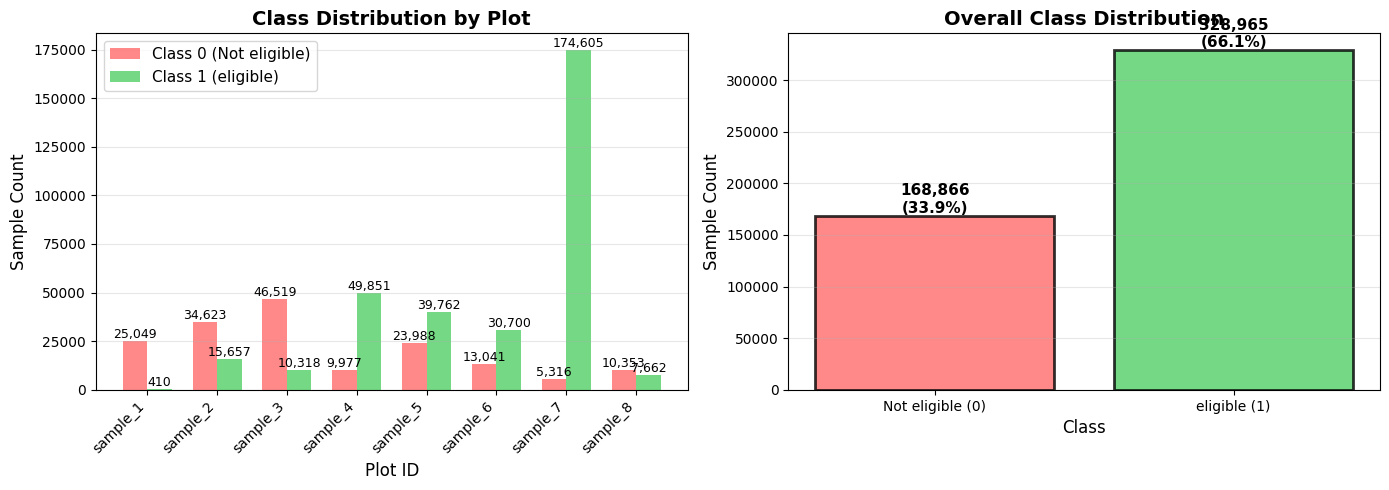


CLASS DISTRIBUTION STATISTICS
Total samples: 497,831
  Class 0: 168,866 samples (33.92%)
  Class 1: 328,965 samples (66.08%)

Imbalance ratio: 1.95:1

Per-plot breakdown:
  sample_1: Class 0=25,049 (98.4%), Class 1=410 (1.6%)
  sample_2: Class 0=34,623 (68.9%), Class 1=15,657 (31.1%)
  sample_3: Class 0=46,519 (81.8%), Class 1=10,318 (18.2%)
  sample_4: Class 0=9,977 (16.7%), Class 1=49,851 (83.3%)
  sample_5: Class 0=23,988 (37.6%), Class 1=39,762 (62.4%)
  sample_6: Class 0=13,041 (29.8%), Class 1=30,700 (70.2%)
  sample_7: Class 0=5,316 (3.0%), Class 1=174,605 (97.0%)
  sample_8: Class 0=10,353 (57.5%), Class 1=7,662 (42.5%)


In [8]:
# ============================================================================
# STEP 5.5: VISUALIZE CLASS DISTRIBUTION BY PLOT
# ============================================================================
# Analyze and visualize the distribution of target classes (0=Not eligible, 1=eligible)
# across different plots to understand data balance

import matplotlib.pyplot as plt

def plot_class_distribution_by_plot(ds):
    """Visualize class distribution across different plots"""
    plot_ids = ds.plot_id.values
    y = ds.y.values
    
    unique_plots = np.unique(plot_ids)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count by plot
    plot_class_counts = {}
    for plot_id in unique_plots:
        mask = plot_ids == plot_id
        unique, counts = np.unique(y[mask], return_counts=True)
        plot_class_counts[plot_id] = dict(zip(unique, counts))
    
    # Plot 1: Class distribution per plot
    plot_ids_sorted = sorted(unique_plots)
    class_0_counts = [plot_class_counts[p].get(0, 0) for p in plot_ids_sorted]
    class_1_counts = [plot_class_counts[p].get(1, 0) for p in plot_ids_sorted]
    
    x = np.arange(len(plot_ids_sorted))
    width = 0.35
    axes[0].bar(x - width/2, class_0_counts, width, label='Class 0 (Not eligible)', alpha=0.8, color='#ff6b6b')
    axes[0].bar(x + width/2, class_1_counts, width, label='Class 1 (eligible)', alpha=0.8, color='#51cf66')
    axes[0].set_xlabel('Plot ID', fontsize=12)
    axes[0].set_ylabel('Sample Count', fontsize=12)
    axes[0].set_title('Class Distribution by Plot', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(plot_ids_sorted, rotation=45, ha='right')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for i, (c0, c1) in enumerate(zip(class_0_counts, class_1_counts)):
        axes[0].text(i - width/2, c0, f'{c0:,}', ha='center', va='bottom', fontsize=9)
        axes[0].text(i + width/2, c1, f'{c1:,}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Overall class distribution
    unique, counts = np.unique(y, return_counts=True)
    colors = ['#ff6b6b', '#51cf66']
    bars = axes[1].bar(unique, counts, alpha=0.8, color=[colors[int(c)] for c in unique], edgecolor='black', linewidth=2)
    axes[1].set_xlabel('Class', fontsize=12)
    axes[1].set_ylabel('Sample Count', fontsize=12)
    axes[1].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xticks(unique)
    axes[1].set_xticklabels(['Not eligible (0)', 'eligible (1)'])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    total = sum(counts)
    for bar, count, cls in zip(bars, counts, unique):
        height = bar.get_height()
        pct = (count / total) * 100
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "=" * 60)
    print("CLASS DISTRIBUTION STATISTICS")
    print("=" * 60)
    print(f"Total samples: {len(y):,}")
    for cls, count in zip(unique, counts):
        pct = (count / len(y)) * 100
        print(f"  Class {cls}: {count:,} samples ({pct:.2f}%)")
    print(f"\nImbalance ratio: {max(counts) / min(counts):.2f}:1")
    print("\nPer-plot breakdown:")
    for plot_id in plot_ids_sorted:
        c0 = plot_class_counts[plot_id].get(0, 0)
        c1 = plot_class_counts[plot_id].get(1, 0)
        total_plot = c0 + c1
        print(f"  {plot_id}: Class 0={c0:,} ({100*c0/total_plot:.1f}%), Class 1={c1:,} ({100*c1/total_plot:.1f}%)")
    print("=" * 60)

# Visualize class distribution
print("📊 Analyzing class distribution...")
plot_class_distribution_by_plot(ds_train)


# ⚖️ HANDLING CLASS IMBALANCE

## Current Situation:
- **Overall imbalance**: 1.95:1 (manageable, but still imbalanced)
- **Per-plot imbalance**: Very severe in some plots (e.g., sample_1: 98.4% vs 1.6%, sample_7: 3.0% vs 97.0%)

## ❌ NOT Recommended: Randomly Dropping Data
**Why not?**
- Loses valuable training data
- May remove important patterns
- Reduces model's ability to learn
- Can hurt generalization

## ✅ Recommended Solutions:

### 1. **Adjust Class Weights** (Easiest, No Data Loss) ⭐⭐⭐
   - Calculate optimal weights based on actual distribution
   - Automatically balances the model's focus
   - No data loss

### 2. **Use Stratified Sampling** (Better Train/Val Split) ⭐⭐
   - Ensures both classes are represented in train/val sets
   - Already using `stratify=y_all` in train_test_split ✅

### 3. **Class Weights** (Implemented) ⭐⭐⭐
   - ✅ **Currently using**: Optimal class weights calculated from data distribution
   - Automatically balances class importance during training
   - Set in `model_config['class_weights']` using `optimal_weights` from STEP 5.6

### 4. **Oversampling (SMOTE)** (Advanced, Optional) ⭐
   - Creates synthetic samples for minority class
   - Can cause overfitting if overused


In [9]:
# ============================================================================
# STEP 5.6: CALCULATE OPTIMAL CLASS WEIGHTS
# ============================================================================
# Calculate balanced class weights to handle imbalance without losing data

from sklearn.utils.class_weight import compute_class_weight

def calculate_optimal_class_weights(y):
    """
    Calculate balanced class weights using sklearn's compute_class_weight
    
    Returns:
    --------
    class_weights : list
        [weight_for_class_0, weight_for_class_1] for CatBoost
    """
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    weight_dict = dict(zip(classes, weights))
    
    print("=" * 60)
    print("OPTIMAL CLASS WEIGHTS CALCULATION")
    print("=" * 60)
    print(f"Class 0 (Not Eligible): {weight_dict[0]:.4f}")
    print(f"Class 1 (Eligible): {weight_dict[1]:.4f}")
    print(f"\nCurrent config uses: [1.0, 3.0]")
    print(f"Recommended: [{weight_dict[0]:.2f}, {weight_dict[1]:.2f}]")
    print("=" * 60)
    
    # Return as list for CatBoost (assuming binary classification: [class_0_weight, class_1_weight])
    if len(classes) == 2:
        return [weight_dict[0], weight_dict[1]]
    return list(weights)

# Calculate optimal weights from your data
y_all = ds_train.y.values
optimal_weights = calculate_optimal_class_weights(y_all)

print(f"\n💡 To use these weights, update your model_config:")
print(f"   class_weights={optimal_weights}")
print(f"\n   Example:")
print(f"   model_config = dict(")
print(f"       ...")
print(f"       class_weights={optimal_weights},  # Balanced weights")
print(f"       ...")
print(f"   )")


OPTIMAL CLASS WEIGHTS CALCULATION
Class 0 (Not Eligible): 1.4740
Class 1 (Eligible): 0.7567

Current config uses: [1.0, 3.0]
Recommended: [1.47, 0.76]

💡 To use these weights, update your model_config:
   class_weights=[1.4740415477360747, 0.7566625628866293]

   Example:
   model_config = dict(
       ...
       class_weights=[1.4740415477360747, 0.7566625628866293],  # Balanced weights
       ...
   )


In [ ]:
# ============================================================================
# STEP 5.7: MULTICOLLINEARITY CHECK
# ============================================================================
# Check for highly correlated features and remove redundant ones
# This should be done BEFORE model training to improve model stability and performance

import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

def check_multicollinearity(X_features_df, correlation_threshold=0.95, vif_threshold=10.0):
    """
    Check for multicollinearity using correlation matrix and VIF
    
    Parameters:
    -----------
    X_features_df : pd.DataFrame
        DataFrame with features (columns) and samples (rows)
    correlation_threshold : float
        Threshold for correlation (default: 0.95)
    vif_threshold : float
        Threshold for VIF (default: 10.0)
        
    Returns:
    --------
    results : dict
        Dictionary with correlation pairs, VIF scores, and recommendations
    """
    print("=" * 60)
    print("MULTICOLLINEARITY CHECK")
    print("=" * 60)
    print(f"Total features: {X_features_df.shape[1]}")
    print(f"Total samples: {X_features_df.shape[0]}\n")
    
    # 1. Correlation Matrix Analysis
    print("📊 Step 1: Correlation Matrix Analysis")
    print("-" * 60)
    corr_matrix = X_features_df.corr().abs()
    
    # Find highly correlated pairs (excluding diagonal)
    high_corr_pairs = []
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if corr_value >= correlation_threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_value
                })
    
    if high_corr_pairs:
        print(f"⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs (|r| >= {correlation_threshold}):")
        # Sort by correlation value
        high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: x['correlation'], reverse=True)
        for idx, pair in enumerate(high_corr_pairs_sorted[:20]):  # Show top 20
            print(f"   {idx+1}. {pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.4f}")
        if len(high_corr_pairs) > 20:
            print(f"   ... and {len(high_corr_pairs) - 20} more pairs")
    else:
        print(f"✅ No highly correlated pairs found (threshold: {correlation_threshold})")
    
    # 2. VIF Analysis (Variance Inflation Factor)
    print(f"\n📊 Step 2: VIF Analysis (Variance Inflation Factor)")
    print("-" * 60)
    
    # Select numeric columns only and handle any remaining NaN values
    X_numeric = X_features_df.select_dtypes(include=[np.number])
    X_numeric = X_numeric.fillna(X_numeric.mean())  # Fill NaN with mean
    
    # Limit to first 100 features for VIF calculation (VIF is computationally expensive)
    # If you have many features, calculate VIF on a sample
    if X_numeric.shape[1] > 100:
        print(f"⚠️ Too many features ({X_numeric.shape[1]}) for full VIF calculation.")
        print(f"   Calculating VIF on first 100 features as sample...")
        X_vif = X_numeric.iloc[:, :100]
        feature_names_vif = X_vif.columns.tolist()
    else:
        X_vif = X_numeric
        feature_names_vif = X_vif.columns.tolist()
    
    try:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = feature_names_vif
        vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(X_vif.shape[1])]
        
        high_vif_features = vif_data[vif_data["VIF"] > vif_threshold].sort_values("VIF", ascending=False)
        
        if len(high_vif_features) > 0:
            print(f"⚠️ Found {len(high_vif_features)} features with high VIF (VIF > {vif_threshold}):")
            for idx, row in high_vif_features.head(20).iterrows():
                print(f"   {row['Feature']}: VIF = {row['VIF']:.2f}")
            if len(high_vif_features) > 20:
                print(f"   ... and {len(high_vif_features) - 20} more features")
        else:
            print(f"✅ No features with high VIF found (threshold: {vif_threshold})")
            
    except Exception as e:
        print(f"⚠️ Could not calculate VIF: {str(e)}")
        print("   (This is normal for very large datasets)")
        high_vif_features = pd.DataFrame()
        vif_data = pd.DataFrame()
    
    # 3. Recommendations
    print(f"\n💡 Recommendations:")
    print("-" * 60)
    
    features_to_remove = set()
    
    # From correlation analysis
    if high_corr_pairs:
        # For each pair, remove one feature (prefer shorter name or first one)
        for pair in high_corr_pairs_sorted:
            feat1, feat2 = pair['feature1'], pair['feature2']
            if feat1 not in features_to_remove and feat2 not in features_to_remove:
                # Remove the second feature (arbitrary choice - could be improved)
                features_to_remove.add(feat2)
        
        print(f"   From correlation: Remove {len(features_to_remove)} features")
    
    # From VIF analysis
    if len(high_vif_features) > 0:
        vif_features_to_remove = set(high_vif_features['Feature'].tolist())
        features_to_remove.update(vif_features_to_remove)
        print(f"   From VIF: {len(vif_features_to_remove)} features flagged")
    
    total_to_remove = len(features_to_remove)
    remaining_features = X_features_df.shape[1] - total_to_remove
    
    print(f"\n   Total features to consider removing: {total_to_remove}")
    print(f"   Remaining features after removal: {remaining_features}")
    print(f"   Reduction: {(total_to_remove/X_features_df.shape[1]*100):.1f}%")
    
    return {
        'correlation_pairs': high_corr_pairs,
        'vif_scores': vif_data if 'vif_data' in locals() else pd.DataFrame(),
        'high_vif_features': high_vif_features if 'high_vif_features' in locals() else pd.DataFrame(),
        'features_to_remove': list(features_to_remove),
        'correlation_matrix': corr_matrix
    }

def remove_multicollinear_features_from_dataset(ds, feature_names, features_to_remove):
    """
    Remove multicollinear features from dataset
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Original dataset with X_features as (sample, features) array
    feature_names : list
        List of all feature names in order (e.g., ['EVI__minimum', 'EVI__mean', ...])
    features_to_remove : list
        List of feature names to remove
        
    Returns:
    --------
    ds_filtered : xarray.Dataset
        Dataset with multicollinear features removed
    feature_names_filtered : list
        List of remaining feature names
    """
    if not features_to_remove:
        print("✅ No features to remove")
        return ds, feature_names
    
    # Find indices of features to keep
    keep_indices = [i for i, name in enumerate(feature_names) if name not in features_to_remove]
    feature_names_filtered = [name for name in feature_names if name not in features_to_remove]
    
    # X_features is stored as (sample, features) - remove columns
    X_filtered = ds.X_features.values[:, keep_indices]
    
    # Create new dataset with filtered features
    # Need to recreate the dataset to avoid coordinate dimension conflicts
    ds_filtered = xr.Dataset(
        {
            "X_features": (("sample", "features"), X_filtered),
            "y": (("sample",), ds.y.values),
            "plot_id": (("sample",), ds.plot_id.values),
            "coord_x": (("sample",), ds.coord_x.values),
            "coord_y": (("sample",), ds.coord_y.values)
        },
        coords={
            "sample": ds.sample.values,
            "features": feature_names_filtered  # Use filtered feature names as coordinates
        }
    )
    
    print(f"✅ Removed {len(features_to_remove)} multicollinear features")
    print(f"   Remaining features: {len(feature_names_filtered)}")
    
    return ds_filtered, feature_names_filtered

# Perform multicollinearity check
print("🔍 Performing multicollinearity check on features...\n")

# Convert X_features to DataFrame for analysis
# Get feature names from the dataset
feature_names = [f'{si}__{feat}' for si in ds_ml.spectral_indices.values 
                 for feat in ds_ml.features.values]

# Create DataFrame from X_features
X_features_df = pd.DataFrame(
    ds_ml.X_features.values.reshape(ds_ml.sizes['sample'], -1),
    columns=feature_names
)

# Run multicollinearity check
multicollinearity_results = check_multicollinearity(
    X_features_df, 
    correlation_threshold=0.95,  # Adjust threshold as needed (0.95 = very high correlation)
    vif_threshold=10.0  # VIF > 10 indicates multicollinearity
)

print("\n" + "=" * 60)
print("✅ Multicollinearity check completed!")
print("=" * 60)


🔍 Performing multicollinearity check on features...



MULTICOLLINEARITY CHECK
Total features: 300
Total samples: 497831

📊 Step 1: Correlation Matrix Analysis
------------------------------------------------------------
⚠️ Found 70 highly correlated feature pairs (|r| >= 0.95):
   1. SAVI__quantile__q_0.3 <-> FCD__ar_coefficient__coeff_1__k_10: 1.0000
   2. SAVI__quantile__q_0.2 <-> FCD__variation_coefficient: 1.0000
   3. SAVI__quantile__q_0.1 <-> FCD__quantile__q_0.3: 1.0000
   4. SAVI__variation_coefficient <-> FCD__ar_coefficient__coeff_5__k_10: 1.0000
   5. SAVI__ar_coefficient__coeff_1__k_10 <-> FCD__ar_coefficient__coeff_4__k_10: 1.0000
   6. SAVI__ar_coefficient__coeff_5__k_10 <-> FCD__fft_coefficient__attr_"abs"__coeff_3: 0.9992
   7. NBR__fft_coefficient__attr_"angle"__coeff_13 <-> FCD__fft_coefficient__attr_"abs"__coeff_3: 0.9985
   8. NDVI__fft_coefficient__attr_"abs"__coeff_2 <-> SAVI__ar_coefficient__coeff_5__k_10: 0.9981
   9. NDVI__fft_coefficient__attr_"abs"__coeff_2 <-> FCD__fft_coefficient__attr_"abs"__coeff_3: 0.9980
 

In [15]:
multicollinearity_results['features_to_remove']

['GNDVI__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
 'GNDVI__minimum',
 'GNDVI__quantile__q_0.1',
 'FCD__ar_coefficient__coeff_5__k_10',
 'GNDVI__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"',
 'NBR__fft_coefficient__attr_"angle"__coeff_13',
 'EVI__fft_coefficient__attr_"abs"__coeff_0',
 'GNDVI__ar_coefficient__coeff_4__k_10',
 'EVI__fft_coefficient__attr_"angle"__coeff_13',
 'EVI__energy_ratio_by_chunks__num_segments_10__segment_focus_5',
 'FCD__fft_coefficient__attr_"angle"__coeff_23',
 'EVI__fft_coefficient__attr_"imag"__coeff_35',
 'GNDVI__fft_coefficient__attr_"abs"__coeff_3',
 'EVI__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
 'EVI__ar_coefficient__coeff_4__k_10',
 'NDVI__fft_coefficient__attr_"abs"__coeff_2',
 'GNDVI__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
 'GNDVI__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)',
 'GNDVI__fft_coefficient__attr_"imag"__coeff_5',
 'EVI__cwt_coefficients__coeff_7__w_2__width

In [16]:
set([l.split('__')[0] for l in multicollinearity_results['features_to_remove']])

{'EVI', 'FCD', 'GNDVI', 'NBR', 'NDVI', 'SAVI'}

In [19]:
ds_train

<xarray.Dataset> Size: 1GB
Dimensions:     (sample: 497831, features: 300)
Coordinates:
  * sample      (sample) int64 4MB 0 1 2 3 4 ... 497827 497828 497829 497830
  * features    (features) <U69 83kB 'EVI__minimum' ... 'FCD__agg_linear_tren...
Data variables:
    X_features  (sample, features) float64 1GB 0.584 0.584 0.5856 ... 0.0 0.0
    y           (sample) int32 2MB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    plot_id     (sample) object 4MB 'sample_2' 'sample_2' ... 'sample_8'
    coord_x     (sample) float64 4MB 5.913e+05 5.913e+05 ... 5.849e+05 5.849e+05
    coord_y     (sample) float64 4MB 9.952e+06 9.952e+06 ... 9.978e+06 9.978e+06

In [24]:
###Optional: Remove highly correlated features
####Uncomment the following lines to automatically remove multicollinear features
if multicollinearity_results['features_to_remove']:
    print("\n🗑️ Removing multicollinear features...")
    ds_train_filtered, feature_names_filtered = remove_multicollinear_features_from_dataset(
        ds_train, 
        feature_names,
        multicollinearity_results['features_to_remove']
    )
    print("✅ Dataset filtered. Use 'ds_train_filtered' for training instead of 'ds_train'")
    print("   Note: Update feature_names to 'feature_names_filtered' if you use filtered dataset")
else:
    print("\n✅ No features removed. Dataset is ready for training.")


🗑️ Removing multicollinear features...
✅ Removed 103 multicollinear features
   Remaining features: 197
✅ Dataset filtered. Use 'ds_train_filtered' for training instead of 'ds_train'
   Note: Update feature_names to 'feature_names_filtered' if you use filtered dataset


In [25]:
ds_train_filtered

<xarray.Dataset> Size: 803MB
Dimensions:     (sample: 497831, features: 197)
Coordinates:
  * sample      (sample) int64 4MB 0 1 2 3 4 ... 497827 497828 497829 497830
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
Data variables:
    X_features  (sample, features) float64 785MB 20.97 0.0755 0.0 ... 0.0 0.0
    y           (sample) int32 2MB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    plot_id     (sample) object 4MB 'sample_2' 'sample_2' ... 'sample_8'
    coord_x     (sample) float64 4MB 5.913e+05 5.913e+05 ... 5.849e+05 5.849e+05
    coord_y     (sample) float64 4MB 9.952e+06 9.952e+06 ... 9.978e+06 9.978e+06

In [26]:
# X_features

In [27]:
# ============================================================================
# STEP 6: IMPORT ALL REQUIRED LIBRARIES
# ============================================================================
# Import all necessary libraries for model training and evaluation

import pandas as pd
import numpy as np
import xarray as xr
import os
import json
import hashlib
from datetime import datetime
import glob

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing (for post-processing predictions)
from skimage.morphology import remove_small_objects
from scipy.ndimage import generic_filter
from skimage.segmentation import clear_border

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


# 📊 MODELING APPROACH

## Single Model Training (What We're Using):
1. **Data**: All plots combined (~497,831 samples, 300 features)
2. **Training**: 
   - Train ONE model on the ENTIRE dataset
   - Random 80/20 train/validation split (not by plot)
   - Model sees data from all plots during training
3. **Output**: 
   - Single model saved as `catboost_{timestamp}.cbm`
   - Timestamp format: `YYYYMMDD_HHMMSS` (e.g., `catboost_20250101_120000.cbm`)
4. **Purpose**: Production-ready model for inference on new areas/pixels

## Key Benefits:
- ✅ Single unified model (not separate models per plot)
- ✅ Timestamped for version tracking
- ✅ Better generalization across all plots
- ✅ Ready for deployment on new data


In [28]:
# ============================================================================
# STEP 7: DEFINE UTILITY FUNCTIONS
# ============================================================================
# Define helper functions for model training and evaluation

def prepare_config(model_config, plot_ids, input_config=dict(), use_proba=False, optimal_threshold=0.5):
    """
    Prepare configuration with unique hash based on model settings and threshold
    
    Parameters:
    -----------
    use_proba : bool
        Whether using probability-based predictions (affects hash)
    optimal_threshold : float
        Threshold value (affects hash to ensure different configs get different cache)
    """
    # Convert numpy array to list for JSON serialization
    if isinstance(plot_ids, np.ndarray):
        plot_ids_list = plot_ids.tolist()
    else:
        plot_ids_list = list(plot_ids)
    
    config = {'model': model_config, 'plots': plot_ids_list, 'sample_weight': True}
    # merge config with input_config
    config.update(input_config)
    
    # Add threshold info to config for tracking
    config['use_proba'] = use_proba
    config['optimal_threshold'] = optimal_threshold
    
    # Create a copy of config for hashing (without verbose for consistency)
    config_for_hash = config.copy()
    if 'verbose' in config_for_hash['model']:
        config_for_hash['model'] = config_for_hash['model'].copy()
        del config_for_hash['model']['verbose']
    
    # Include threshold and use_proba in hash to ensure different configs get different cache
    config_for_hash['hash_meta'] = {
        'use_proba': use_proba,
        'optimal_threshold': optimal_threshold
    }
    
    config['hash'] = hashlib.md5(json.dumps(config_for_hash, sort_keys=True).encode('utf-8')).hexdigest()
    
    if 'verbose' in config['model']:
        del config['model']['verbose']
    
    # create cache directory if it does not exist
    if not os.path.exists(f"/mnt/data/cache/{config['hash']}"):
        os.makedirs(f"/mnt/data/cache/{config['hash']}", exist_ok=True)
        json.dump(config, open(f"/mnt/data/cache/{config['hash']}/config.json", 'w'))

    return config

def remove_small_objects_eligibility(da, min_size, mode_filter_size):
    """
    For each season slice in da (dims: season, y, x), remove connected
    components smaller than `min_size` and then apply a mode filter of
    size `mode_filter_size`. Returns a new DataArray named <original>_cleaned.
    """
    def mode_filter(values):
        vals = values.astype(int)
        return np.bincount(vals).argmax()

    # original nan‐mask
    nan_mask = np.isnan(da.values)
    # boolean array for morphology
    arr = da.values.astype(bool)
    # replace NaNs with median
    arr[np.isnan(arr)] = np.nanmedian(arr)
    cleaned = np.zeros_like(arr, dtype=bool)

    cleaned = generic_filter(
        arr,
        function=mode_filter,
        size=mode_filter_size,
        mode='nearest'
    )
    # process each season slice
    cleaned = remove_small_objects(cleaned, min_size=min_size)
    # build output DataArray
    cleaned_float = cleaned.astype(float)
    # reintroduce NaNs
    cleaned_float[nan_mask] = np.nan

    return xr.DataArray(
        cleaned_float,
        coords=da.coords,
        dims=da.dims,
        name=f"{da.name}_cleaned"
    )
    
def plot_confusion_matrix(y_val, y_var_pred, class_names=['Not Eligible', 'Eligible'], sample_weight=None, dataset="training"):
    cm = confusion_matrix(y_val, y_var_pred, normalize='true', sample_weight=sample_weight)
    # plot confusion matrix
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > 0.5 else 'black')
    # add TP, FP, TN, FN labels
    plt.xticks(ticks=range(cm.shape[1]), labels=class_names)
    plt.yticks(ticks=range(cm.shape[0]), labels=class_names)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix on {dataset} with {"sample_weight" if sample_weight is not None else "no sample_weight"}')
    plt.show()

def plot_roc_curve(X_features, y, model):
    # Compute predicted probabilities for the positive class
    y_scores = model.predict_proba(X_features)[:, 1]
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    # Compute area under the ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_classification_report(y_true, y_pred, class_names=None, figsize=(8, 6), cmap='Blues', sample_weight=None):
    """
    Plots a heatmap of precision, recall and f1-score from a classification_report.
    y_true: array-like of true labels
    y_pred: array-like of predicted labels
    class_names: list of class names in the order of label encoding
    """
    from sklearn.metrics import classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    # compute report
    report_dict = classification_report(y_true, y_pred,
                                        target_names=class_names,
                                        output_dict=True,
                                        sample_weight=sample_weight)
    report_df = pd.DataFrame(report_dict).T
    # drop the accuracy row and support column
    report_df = report_df.iloc[:-3, :-1]

    plt.figure(figsize=figsize)
    sns.heatmap(report_df.astype(float),
                annot=True,
                cmap=cmap,
                cbar=False,
                fmt=".2f")
    plt.title('Classification Report')
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.yticks(rotation=0)
    plt.show()

def plot_roc_curve2(X_features, y, model):
    # Compute predicted probabilities for the positive class
    y_scores = model.predict_proba(X_features)[:, 1]

    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve')
    # fill area under the ROC curve
    plt.fill_between(fpr, tpr, color='blue', alpha=0.2, 
                     label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')

    # Annotate thresholds every Nth point
    step = max(1, len(thresholds) // 20)
    for idx in range(0, len(thresholds), step):
        plt.text(fpr[idx], tpr[idx], f"{thresholds[idx]:.2f}",
                 fontsize=8, ha='center', va='bottom', color='red')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)



In [29]:
# ============================================================================
# STEP 8: DEFINE TRAINING FUNCTION
# ============================================================================
# Function to train a single model on the entire dataset

def train_full_area_model(ds_full, config, validation_split=0.2, random_seed=42):
    """
    Train a single model on the entire dataset (all plots combined)
    
    Parameters:
    -----------
    ds_full : xarray.Dataset
        Full dataset with all plots
    config : dict
        Model configuration dictionary
    validation_split : float
        Fraction of data to use for validation (0.2 = 20%)
    random_seed : int
        Random seed for train/val split
        
    Returns:
    --------
    model : CatBoostClassifier
        Trained model
    """
    # Extract all data (using class_weights for imbalance handling, not sample weights)
    X_all = ds_full.X_features.values
    y_all = ds_full.y.values
    
    # Split into train and validation sets (random split, not by plot)
    from sklearn.model_selection import train_test_split
    
    # Split into train and validation sets (random split, not by plot)
    # Store indices to ensure we can recreate the same split later
    train_indices, val_indices = train_test_split(
        np.arange(len(X_all)),
        test_size=validation_split,
        random_state=random_seed,
        stratify=y_all  # Maintain class distribution
    )
    
    X_train = X_all[train_indices]
    X_val = X_all[val_indices]
    y_train = y_all[train_indices]
    y_val = y_all[val_indices]
    
    # Store indices in config for later use
    config['train_indices'] = train_indices.tolist()
    config['val_indices'] = val_indices.tolist()
    
    print(f"📊 Training on full area:")
    print(f"   Train samples: {len(X_train):,}")
    print(f"   Validation samples: {len(X_val):,}")
    print(f"   Total features: {X_train.shape[1]}")
    if 'class_weights' in config['model']:
        print(f"   Class weights: {config['model']['class_weights']} (handling class imbalance)")
    
    # Create CatBoost model (class_weights are already set in config['model'])
    catboost_model = CatBoostClassifier(**config['model'])
    
    # Train model (class_weights handle imbalance automatically)
    catboost_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=config['model'].get('verbose', 100)
    )
    
    # Save model with timestamp (single file for entire area, not per-plot)
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f"/mnt/data/cache/{config['hash']}/catboost_{timestamp}.cbm"
    catboost_model.save_model(model_path)
    print(f"✅ Model saved to: {model_path}")
    
    # Store model path in config for later retrieval
    config['model_path'] = model_path
    config['timestamp'] = timestamp
    
    # Evaluate on validation set
    y_val_pred = catboost_model.predict(X_val)
    from sklearn.metrics import accuracy_score, classification_report
    
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"\n📈 Validation Accuracy: {accuracy:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=['Not Eligible', 'Eligible']))
    
    return catboost_model, model_path


def load_full_area_model(config, timestamp=None):
    """
    Load the saved full-area model for inference
    
    Parameters:
    -----------
    config : dict
        Configuration dictionary (must have 'hash' key)
    timestamp : str, optional
        Specific timestamp to load (format: YYYYMMDD_HHMMSS)
        If None, loads the latest model or uses config['model_path']
        
    Returns:
    --------
    model : CatBoostClassifier
        Loaded model ready for prediction
    model_path : str
        Path to the loaded model
    """
    # If timestamp is provided, use it
    if timestamp:
        model_path = f"/mnt/data/cache/{config['hash']}/catboost_{timestamp}.cbm"
    # If config has model_path stored, use it
    elif 'model_path' in config:
        model_path = config['model_path']
    # Otherwise, find the latest model
    else:
        cache_dir = f"/mnt/data/cache/{config['hash']}"
        model_files = glob.glob(f"{cache_dir}/catboost_*.cbm")
        
        if not model_files:
            raise FileNotFoundError(f"No models found in {cache_dir}")
        
        # Sort by modification time and get the latest
        model_path = max(model_files, key=os.path.getmtime)
        print(f"📂 Found latest model: {os.path.basename(model_path)}")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at: {model_path}")
    
    model = CatBoostClassifier()
    model.load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")
    
    return model, model_path

print("✅ Training functions defined")


✅ Training functions defined


In [30]:
# ============================================================================
# STEP 9: CONFIGURE AND TRAIN MODEL
# ============================================================================
# Define model hyperparameters and train single model on entire dataset

ds_train = ds_train_filtered #UPDATED AFTER MULTICOLLINEARITY CHECK

# Get plot IDs for config (needed for hash generation)
plot_ids = np.unique(ds_train['plot_id'].values)
print(f"📊 Found {len(plot_ids)} unique plots: {plot_ids}")

# Use optimal class weights if calculated, otherwise use default
if 'optimal_weights' in globals():
    class_weights_to_use = optimal_weights
    print(f"✅ Using calculated optimal class weights: {class_weights_to_use}")
else:
    # Fallback to default if optimal_weights not calculated
    class_weights_to_use = [1.0, 3.0]
    print(f"⚠️ Using default class weights: {class_weights_to_use}")
    print(f"   (Run STEP 5.6 to calculate optimal weights)")

# Define CatBoost model configuration
model_config = dict(
    iterations=3000,              # Maximum number of trees
    learning_rate=0.01,           # Learning rate
    eval_metric='Logloss',        # Evaluation metric
    l2_leaf_reg=6,                # L2 regularization
    random_seed=42,                # Random seed for reproducibility
    early_stopping_rounds=100,    # Stop if no improvement for 100 rounds
    verbose=100,                  # Print progress every 100 iterations
    use_best_model=True,          # Use best model from validation
    depth=4,                      # Tree depth
    class_weights=class_weights_to_use,  # Optimal balanced weights (or default)
)

# Prepare configuration with unique hash
# Note: We're using class_weights (set above using optimal_weights) to handle class imbalance
#       This is more effective than sample weights for this use case
config_full = prepare_config(
    model_config, 
    plot_ids, 
    {'sample_weight': False, 'force_retrain': False}  # Not using sample weights - class_weights handle imbalance
)

print(f"📝 Config hash: {config_full['hash']}")

# Train single model on entire area
print("\n🚀 Training single model on entire area...")
print("=" * 60)
model_full, model_path = train_full_area_model(
    ds_train, 
    config_full, 
    validation_split=0.2,  # 20% for validation, 80% for training
    random_seed=42
)

print("\n" + "=" * 60)
print("✅ Single model trained and saved!")
print(f"   Model path: {model_path}")
print(f"   Timestamp: {config_full.get('timestamp', 'N/A')}")
print(f"   Config hash: {config_full['hash']}")


📊 Found 8 unique plots: ['sample_1' 'sample_2' 'sample_3' 'sample_4' 'sample_5' 'sample_6'
 'sample_7' 'sample_8']
✅ Using calculated optimal class weights: [1.4740415477360747, 0.7566625628866293]
📝 Config hash: 39d5a40844ea382e3524e85e3075152c

🚀 Training single model on entire area...
📊 Training on full area:
   Train samples: 398,264
   Validation samples: 99,567
   Total features: 197
   Class weights: [1.4740415477360747, 0.7566625628866293] (handling class imbalance)
0:	learn: 0.6876272	test: 0.6875491	best: 0.6875491 (0)	total: 484ms	remaining: 24m 10s
100:	learn: 0.4514643	test: 0.4515484	best: 0.4515484 (100)	total: 17.3s	remaining: 8m 15s
200:	learn: 0.4017335	test: 0.4020623	best: 0.4020623 (200)	total: 32.8s	remaining: 7m 36s
300:	learn: 0.3813288	test: 0.3818331	best: 0.3818331 (300)	total: 47.7s	remaining: 7m 7s
400:	learn: 0.3697308	test: 0.3703809	best: 0.3703809 (400)	total: 1m 2s	remaining: 6m 46s
500:	learn: 0.3613221	test: 0.3621067	best: 0.3621067 (500)	total: 1m 

✅ Using model from training
✅ Using stored train/val split indices from training

📊 Model Performance Summary:
   Training Accuracy: 0.8638
   Validation Accuracy: 0.8613

📈 Confusion Matrix (Validation Set):


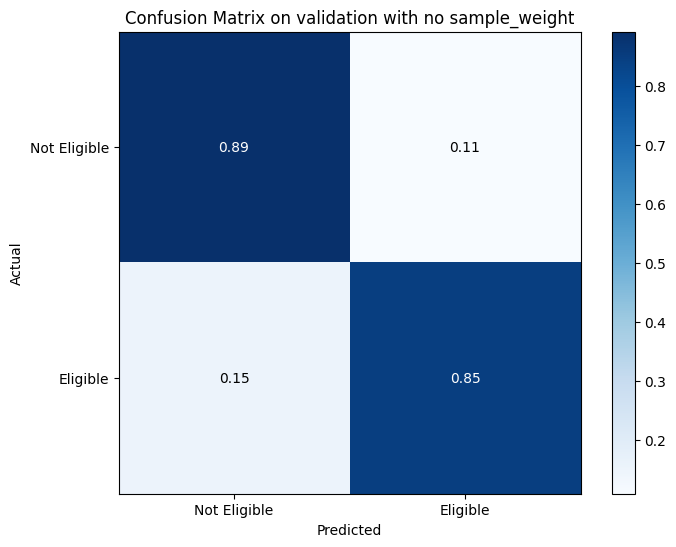

In [ ]:
# ============================================================================
# STEP 10: EVALUATE TRAINED MODEL
# ============================================================================
# Evaluate the trained model on validation set and visualize results
# Note: model_full and model_path are available from the previous cell

# Use the model from training (or reload if needed)
if 'model_full' in globals():
    model_eval = model_full
    print("✅ Using model from training")
else:
    # If model_full not available, load it
    model_eval, _ = load_full_area_model(config_full)

# Get the exact same train/val split used during training
# (No sample weights needed - using class_weights instead)
X_all = ds_train.X_features.values
y_all = ds_train.y.values

# Use stored indices from training (if available) or recreate with same seed
if 'val_indices' in config_full:
    val_indices = np.array(config_full['val_indices'])
    train_indices = np.array(config_full['train_indices'])
    print("✅ Using stored train/val split indices from training")
else:
    # Fallback: recreate split with same seed
    train_indices, val_indices = train_test_split(
        np.arange(len(X_all)),
        test_size=0.2,
        random_state=42,
        stratify=y_all
    )
    print("⚠️ Recreating split (stored indices not found)")

X_train_eval = X_all[train_indices]
X_val_eval = X_all[val_indices]
y_train_eval = y_all[train_indices]
y_val_eval = y_all[val_indices]

# Get predictions
y_train_pred = model_eval.predict(X_train_eval)
y_val_pred = model_eval.predict(X_val_eval)

# Calculate accuracies
train_acc = accuracy_score(y_train_eval, y_train_pred)
val_acc = accuracy_score(y_val_eval, y_val_pred)

print(f"\n📊 Model Performance Summary:")
print(f"   Training Accuracy: {train_acc:.4f}")
print(f"   Validation Accuracy: {val_acc:.4f}")

# Plot confusion matrix
print("\n📈 Confusion Matrix (Validation Set):")
plot_confusion_matrix(y_val_eval, y_val_pred, dataset="validation")



📈 ROC Curve:


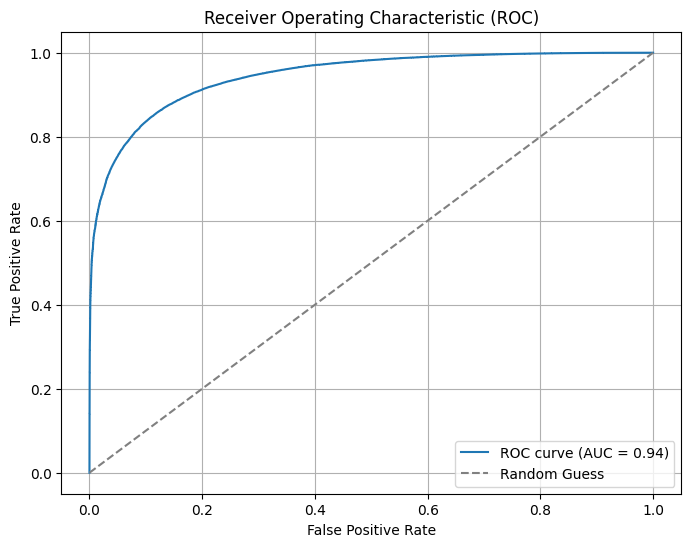


📊 Detailed Classification Report:
              precision    recall  f1-score   support

Not Eligible       0.75      0.89      0.81     33773
    Eligible       0.94      0.85      0.89     65794

    accuracy                           0.86     99567
   macro avg       0.84      0.87      0.85     99567
weighted avg       0.87      0.86      0.86     99567


🔍 Top 20 Most Important Features:
                                                         feature  importance
                       FCD__fft_coefficient__attr_"abs"__coeff_0    7.106706
                                                       FCD__mean    5.799178
                                                       NBR__mean    5.745326
                                            NBR__quantile__q_0.3    5.165062
                       NBR__fft_coefficient__attr_"abs"__coeff_0    4.939041
                      NDVI__fft_coefficient__attr_"abs"__coeff_0    4.708333
   FCD__energy_ratio_by_chunks__num_segments_10__segment_focus_3

In [32]:
# ============================================================================
# STEP 11: ADDITIONAL EVALUATION (OPTIONAL)
# ============================================================================
# Additional evaluation metrics and visualizations

# Use model_eval from previous cell
if 'model_eval' not in globals():
    model_eval = model_full if 'model_full' in globals() else load_full_area_model(config_full)[0]

# Plot ROC curve
print("\n📈 ROC Curve:")
plot_roc_curve(X_val_eval, y_val_eval, model_eval)

# Detailed classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_val_eval, y_val_pred, target_names=['Not Eligible', 'Eligible']))

# Feature importance (top 20)
print("\n🔍 Top 20 Most Important Features:")
feature_importance = model_eval.get_feature_importance(type='PredictionValuesChange')
feature_names = ds_train.coords['features'].values
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(20).to_string(index=False))

# ✅ Training Complete!

## Summary:
- **Model Type**: Single CatBoost classifier trained on entire dataset
- **Training Data**: All plots combined (~497,831 samples)
- **Features**: 300 features (50 tsfresh features × 6 spectral indices)
- **Model Saved**: `catboost_{timestamp}.cbm` with timestamp for versioning
- **Ready for**: Inference on new areas/pixels

## Next Steps:
1. Use `load_full_area_model(config_full)` to load the model
2. Apply model to new data: `predictions = model.predict(X_new)`
3. Optionally apply post-processing (remove_small_objects_eligibility) to clean predictions



🔍 Preparing predictions for entire dataset...
📊 Getting predictions for all samples...


   Total samples in ds_train: 497,831
   Total predictions: 497,831

📋 ds_ml structure:
   Dimensions: {'sample': 497831, 'features': 50, 'timestep': 11, 'spectral_indices': 6}
   Has 'eligibility' variable: True
   Total samples in ds_ml: 497,831

✅ Predictions mapped:
   Samples with predictions: 497,831 (100.0%)
   Samples without predictions: 0

✅ Created ds_ml_pred with variables:
   - eligibility (actual from ds_ml)
   - eligibility_pred (model predictions)
   - All other variables from ds_ml

🔧 Post-processing: Removing small objects (< 0.25 ha)
   Pixel size: 10.0 × 10.0 m
   Pixel area: 0.0100 ha
   Minimum size: 0.25 ha = 25 pixels

🧹 Applying post-processing to predictions...
✅ Post-processing completed!
   Added 'eligibility_pred_cleaned' to ds_ml_pred
   Small objects (< 0.25 ha) removed and merged with surrounding pixels

🗺️  Map Visualization: Predictions vs Actual (Full Dataset)
   Found 8 unique plots: ['sample_1' 'sample_2' 'sample_3' 'sample_4' 'sample_5' 'sample_6'


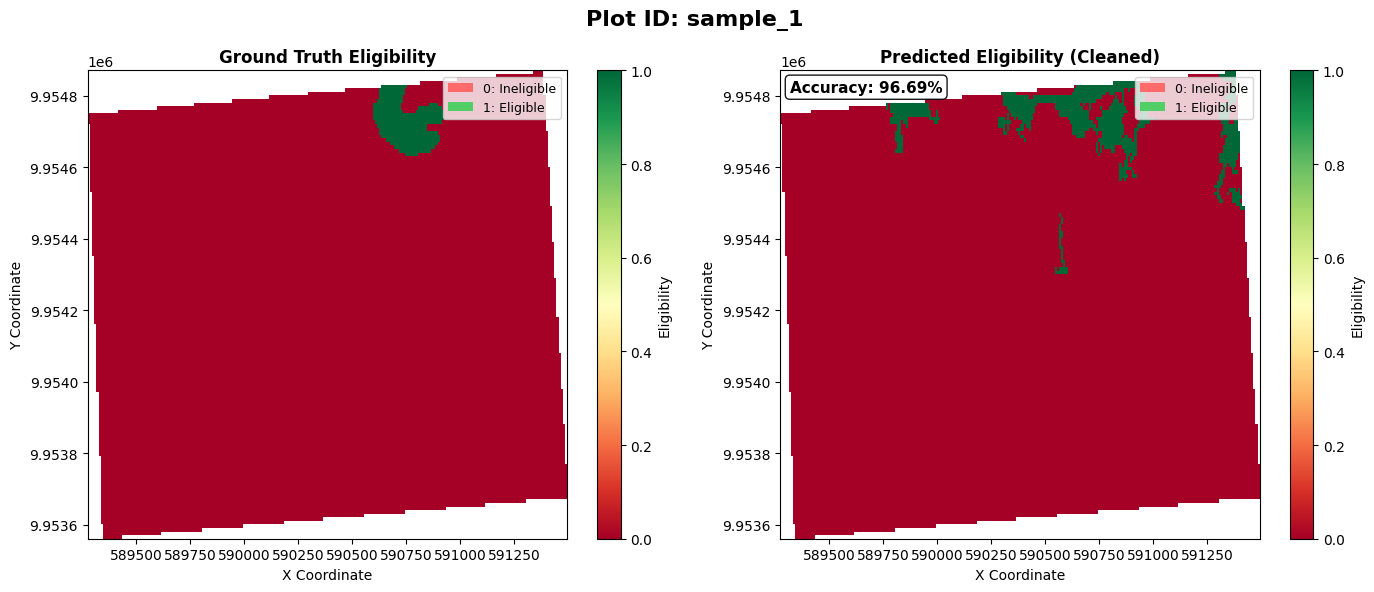


Plot sample_1:
  Accuracy: 96.69% (25,459 samples with predictions)
  Total pixels in plot: 25,459
  Pixels with predictions: 25,459
  Actual - Ineligible: 25,049, Eligible: 410
  Predicted - Ineligible: 24,452, Eligible: 1,007

  Plot sample_2:
    Grid size: 202 × 313 = 63,226 pixels
    Actual samples: 50,280
    Coverage: 79.5%
    Filled pixels: 50,280 (79.5% of grid)


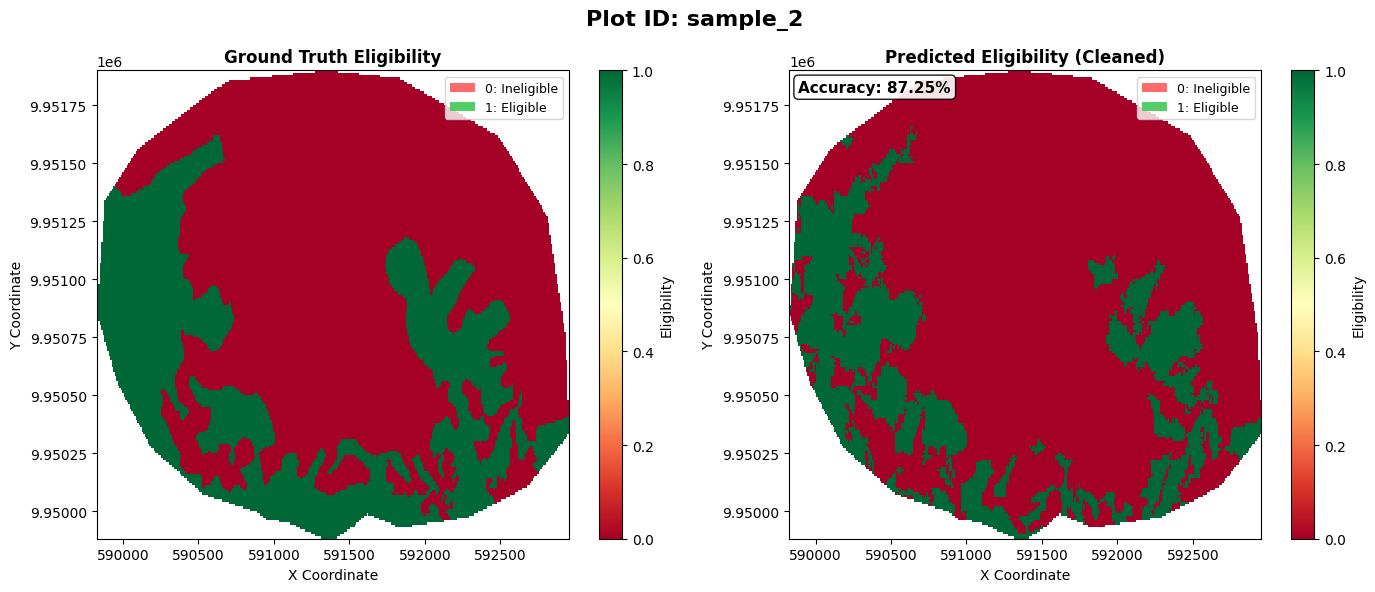


Plot sample_2:
  Accuracy: 87.25% (50,280 samples with predictions)
  Total pixels in plot: 50,280
  Pixels with predictions: 50,280
  Actual - Ineligible: 34,623, Eligible: 15,657
  Predicted - Ineligible: 39,109, Eligible: 11,171

  Plot sample_3:
    Grid size: 240 × 314 = 75,360 pixels
    Actual samples: 56,837
    Coverage: 75.4%
    Filled pixels: 56,837 (75.4% of grid)


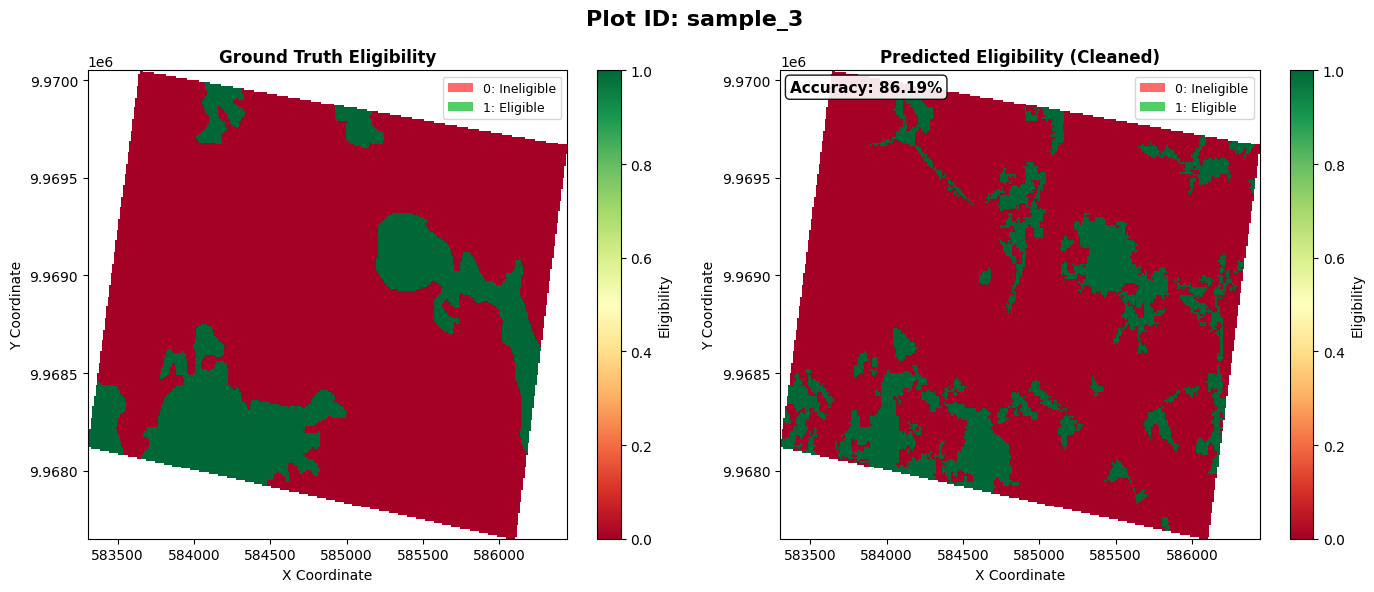


Plot sample_3:
  Accuracy: 86.19% (56,837 samples with predictions)
  Total pixels in plot: 56,837
  Pixels with predictions: 56,837
  Actual - Ineligible: 46,519, Eligible: 10,318
  Predicted - Ineligible: 47,231, Eligible: 9,606

  Plot sample_4:
    Grid size: 216 × 309 = 66,744 pixels
    Actual samples: 59,828
    Coverage: 89.6%
    Filled pixels: 59,828 (89.6% of grid)


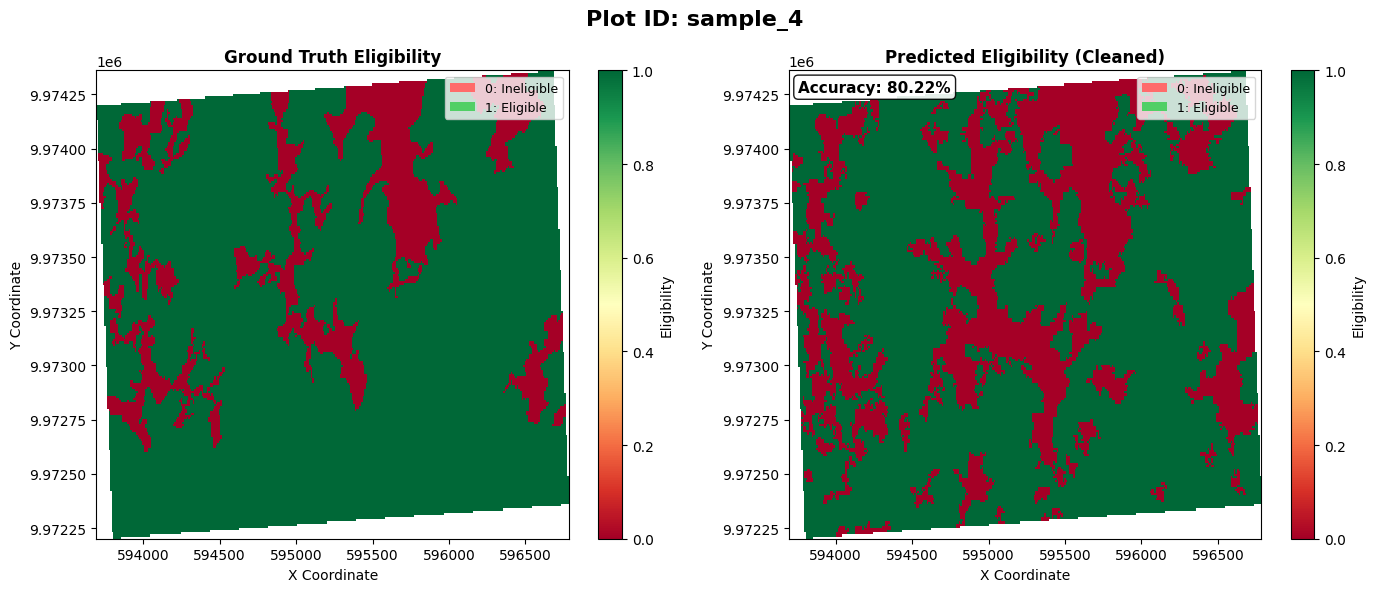


Plot sample_4:
  Accuracy: 80.22% (59,828 samples with predictions)
  Total pixels in plot: 59,828
  Pixels with predictions: 59,828
  Actual - Ineligible: 9,977, Eligible: 49,851
  Predicted - Ineligible: 17,656, Eligible: 42,172

  Plot sample_5:
    Grid size: 194 × 331 = 64,214 pixels
    Actual samples: 63,750
    Coverage: 99.3%
    Filled pixels: 63,750 (99.3% of grid)


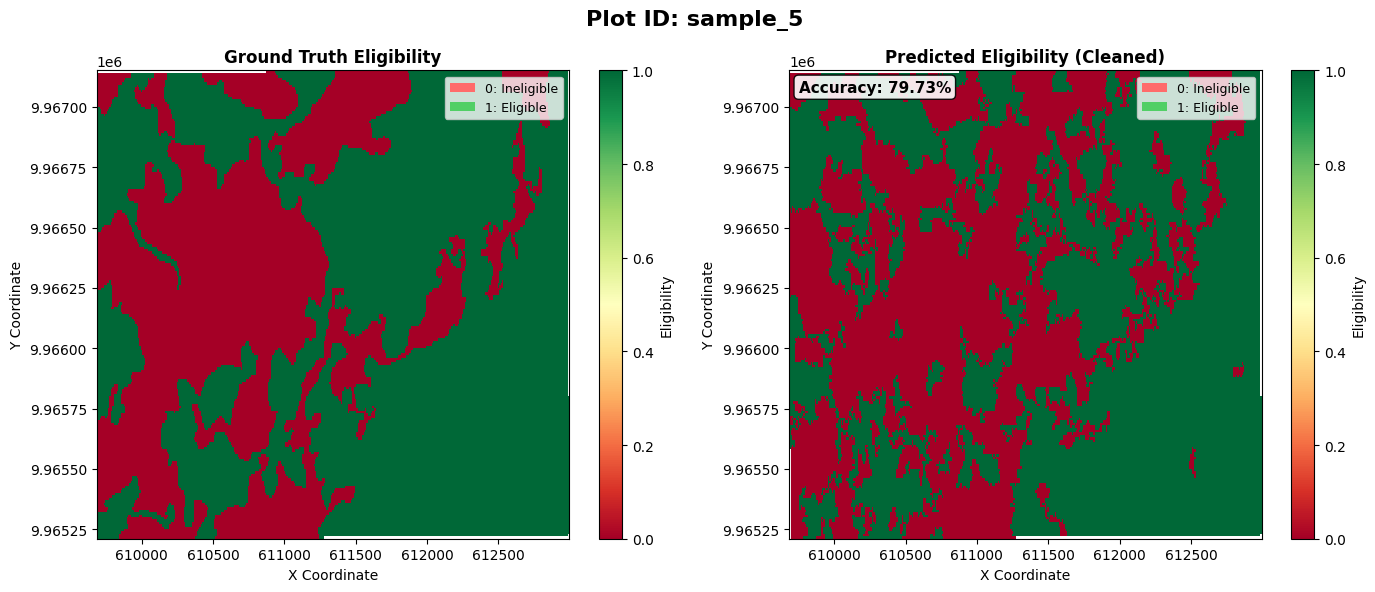


Plot sample_5:
  Accuracy: 79.73% (63,750 samples with predictions)
  Total pixels in plot: 63,750
  Pixels with predictions: 63,750
  Actual - Ineligible: 23,988, Eligible: 39,762
  Predicted - Ineligible: 27,912, Eligible: 35,838

  Plot sample_6:
    Grid size: 166 × 272 = 45,152 pixels
    Actual samples: 43,741
    Coverage: 96.9%
    Filled pixels: 43,741 (96.9% of grid)


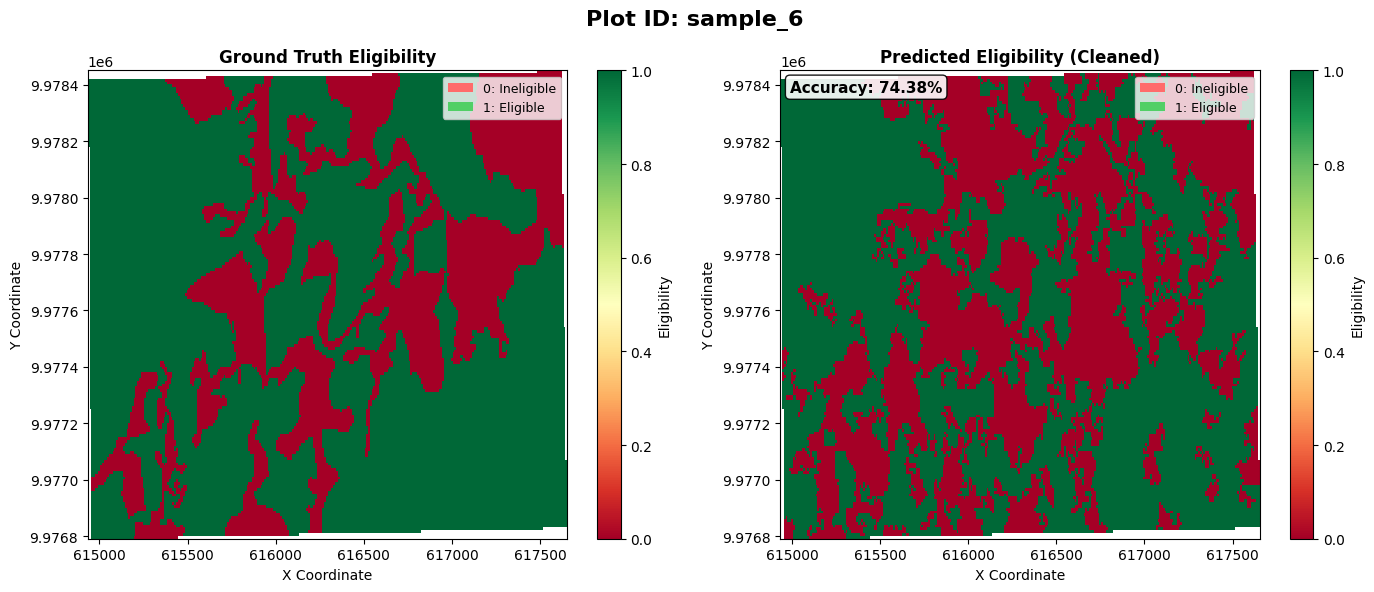


Plot sample_6:
  Accuracy: 74.38% (43,741 samples with predictions)
  Total pixels in plot: 43,741
  Pixels with predictions: 43,741
  Actual - Ineligible: 13,041, Eligible: 30,700
  Predicted - Ineligible: 18,561, Eligible: 25,180

  Plot sample_7:
    Grid size: 371 × 501 = 185,871 pixels
    Actual samples: 179,921
    Coverage: 96.8%
    Filled pixels: 179,921 (96.8% of grid)


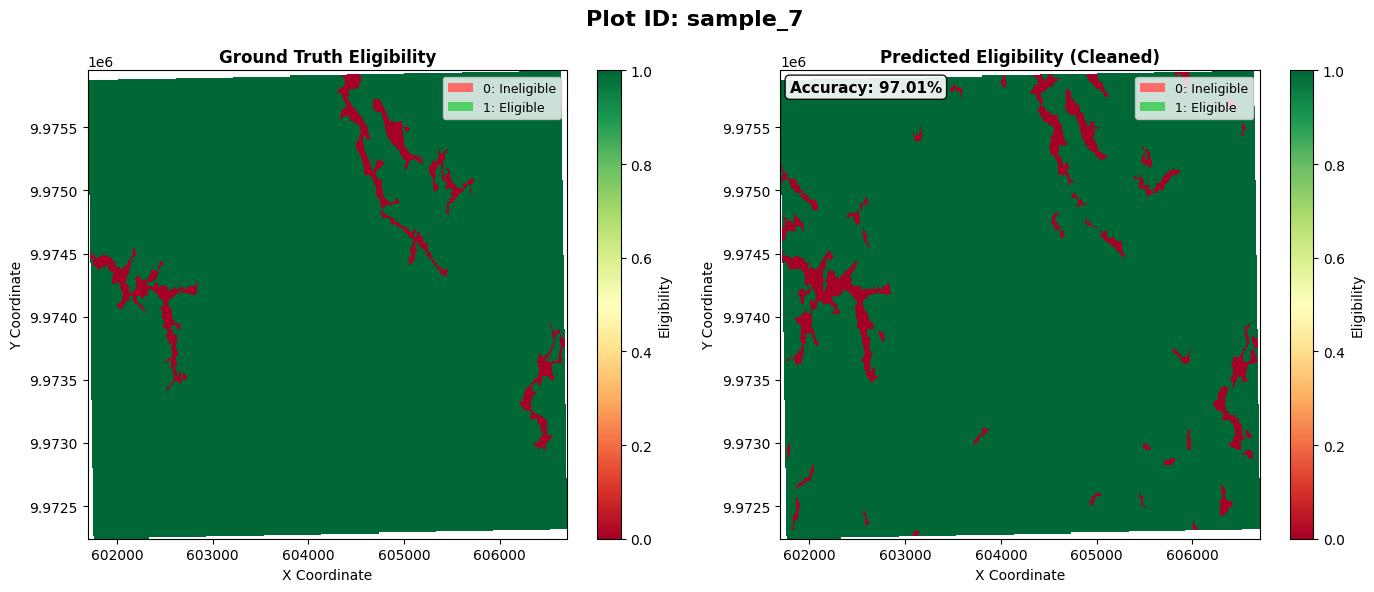


Plot sample_7:
  Accuracy: 97.01% (179,921 samples with predictions)
  Total pixels in plot: 179,921
  Pixels with predictions: 179,921
  Actual - Ineligible: 5,316, Eligible: 174,605
  Predicted - Ineligible: 7,713, Eligible: 172,208

  Plot sample_8:
    Grid size: 120 × 156 = 18,720 pixels
    Actual samples: 18,015
    Coverage: 96.2%
    Filled pixels: 18,015 (96.2% of grid)


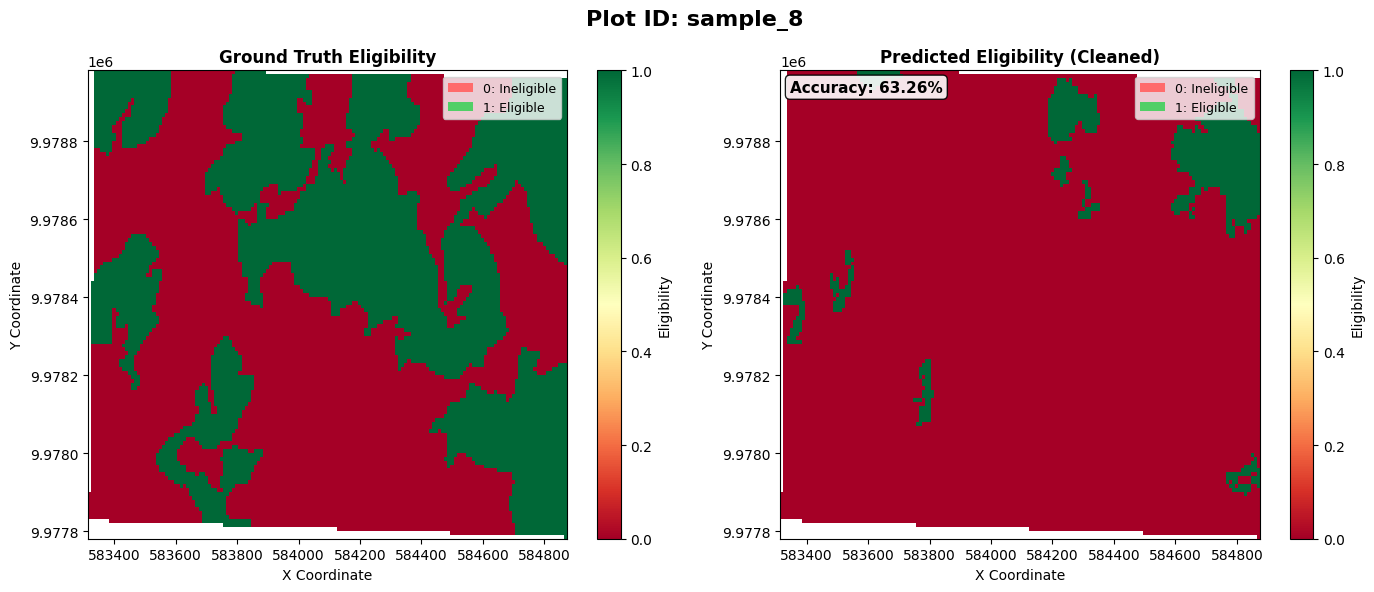


Plot sample_8:
  Accuracy: 63.26% (18,015 samples with predictions)
  Total pixels in plot: 18,015
  Pixels with predictions: 18,015
  Actual - Ineligible: 10,353, Eligible: 7,662
  Predicted - Ineligible: 16,845, Eligible: 1,170

✅ Map visualization completed!


In [39]:
# ============================================================================
# MAP VISUALIZATION: PREDICTIONS VS ACTUAL PER PLOT
# ============================================================================
# Visualize predictions vs actual eligibility on maps using xarray spatial plotting
# Using ENTIRE dataset from ds_ml (not just validation set)

print("\n🔍 Preparing predictions for entire dataset...")
print("=" * 60)

# Get all predictions (both train and validation)
print("📊 Getting predictions for all samples...")
X_all = ds_train.X_features.values
y_all = ds_train.y.values

# Get predictions for ALL samples (train + validation)
y_all_pred = model_eval.predict(X_all)

# Get sample IDs from ds_train (these correspond to ds_ml sample indices)
sample_ids_train = ds_train.sample.values  # These are the indices in ds_ml

print(f"   Total samples in ds_train: {len(sample_ids_train):,}")
print(f"   Total predictions: {len(y_all_pred):,}")

# Create a mapping from sample ID to prediction
sample_to_pred = dict(zip(sample_ids_train, y_all_pred.astype(float)))

# Check ds_ml structure
print(f"\n📋 ds_ml structure:")
print(f"   Dimensions: {dict(ds_ml.sizes)}")
print(f"   Has 'eligibility' variable: {'eligibility' in ds_ml.data_vars}")
print(f"   Total samples in ds_ml: {len(ds_ml.sample):,}")

# Create eligibility_pred array for ds_ml
# Initialize with NaN for samples not in training set
eligibility_pred = np.full(len(ds_ml.sample), np.nan, dtype=float)

# Fill predictions for samples that were in training
ds_ml_sample_ids = ds_ml.sample.values
for i, sample_id in enumerate(ds_ml_sample_ids):
    if sample_id in sample_to_pred:
        eligibility_pred[i] = sample_to_pred[sample_id]

# Count how many predictions we have
n_predicted = np.sum(~np.isnan(eligibility_pred))
print(f"\n✅ Predictions mapped:")
print(f"   Samples with predictions: {n_predicted:,} ({n_predicted/len(ds_ml.sample):.1%})")
print(f"   Samples without predictions: {np.sum(np.isnan(eligibility_pred)):,}")

# Create ds_ml_pred with eligibility (actual) and eligibility_pred (predicted)
ds_ml_pred = ds_ml.copy(deep=True)
ds_ml_pred['eligibility_pred'] = (('sample',), eligibility_pred)

print(f"\n✅ Created ds_ml_pred with variables:")
print(f"   - eligibility (actual from ds_ml)")
print(f"   - eligibility_pred (model predictions)")
print(f"   - All other variables from ds_ml")

# ============================================================================
# POST-PROCESSING: REMOVE SMALL OBJECTS FROM PREDICTIONS
# ============================================================================
# Remove small isolated patches (< 0.25 ha) and merge with surrounding pixels

def remove_small_objects_2d(pred_array, min_size_pixels, connectivity=1):
    """
    Remove small objects from 2D prediction array
    
    Parameters:
    -----------
    pred_array : np.ndarray
        2D array with predictions (0 or 1, can have NaN)
    min_size_pixels : int
        Minimum size in pixels to keep
    connectivity : int
        Connectivity for connected components (1=4-connected, 2=8-connected)
        
    Returns:
    --------
    cleaned_array : np.ndarray
        Array with small objects removed (merged with surrounding majority class)
    """
    from skimage.morphology import remove_small_objects
    from scipy.ndimage import generic_filter
    
    # Create a copy
    cleaned = pred_array.copy()
    
    # Handle NaN values - use mode of surrounding pixels
    nan_mask = np.isnan(cleaned)
    if np.any(nan_mask):
        # Fill NaN with mode of non-NaN neighbors
        def mode_filter(values):
            vals = values[~np.isnan(values)]
            if len(vals) == 0:
                return np.nan
            return np.bincount(vals.astype(int)).argmax()
        
        # Apply filter to entire array, then use only where we have NaN
        filtered = generic_filter(cleaned, mode_filter, size=3, mode='constant', cval=np.nan)
        # Only fill NaN positions with filtered values
        cleaned[nan_mask] = filtered[nan_mask]
    
    # Convert to binary (0 or 1) for each class
    # Process eligible class (1)
    eligible_mask = (cleaned == 1).astype(bool)
    if np.any(eligible_mask):
        # Remove small eligible objects
        eligible_cleaned = remove_small_objects(eligible_mask, min_size=min_size_pixels, connectivity=connectivity)
        # Update: keep only large eligible objects, rest become ineligible
        cleaned[eligible_cleaned] = 1
        cleaned[eligible_mask & ~eligible_cleaned] = 0
    
    # Process ineligible class (0) - remove small ineligible objects
    ineligible_mask = (cleaned == 0).astype(bool)
    if np.any(ineligible_mask):
        # Remove small ineligible objects
        ineligible_cleaned = remove_small_objects(ineligible_mask, min_size=min_size_pixels, connectivity=connectivity)
        # Update: keep only large ineligible objects, rest become eligible (merge with surrounding)
        cleaned[ineligible_cleaned] = 0
        cleaned[ineligible_mask & ~ineligible_cleaned] = 1
    
    # Restore NaN values
    cleaned[nan_mask] = np.nan
    
    return cleaned

# Calculate pixel size from coordinate spacing
print("\n🔧 Post-processing: Removing small objects (< 0.25 ha)")
print("=" * 60)

# Compute plot_id values if they're chunked (needed for post-processing)
if hasattr(ds_ml_pred['plot_id'].values, 'compute'):
    plot_ids = ds_ml_pred['plot_id'].values.compute()
else:
    plot_ids = ds_ml_pred['plot_id'].values

# Get unique plot IDs
unique_plot_ids = np.unique(plot_ids)

# Get coordinate spacing from a sample plot to determine pixel size
sample_plot_id = unique_plot_ids[0]
plot_mask_sample = plot_ids == sample_plot_id
x_coords_sample = ds_ml_pred['coord_x'].isel(sample=plot_mask_sample).values
y_coords_sample = ds_ml_pred['coord_y'].isel(sample=plot_mask_sample).values

if hasattr(x_coords_sample, 'compute'):
    x_coords_sample = x_coords_sample.compute()
    y_coords_sample = y_coords_sample.compute()

# Calculate pixel size (assuming regular grid)
x_unique_sample = np.unique(x_coords_sample)
y_unique_sample = np.unique(y_coords_sample)

if len(x_unique_sample) > 1 and len(y_unique_sample) > 1:
    pixel_size_x = np.abs(x_unique_sample[1] - x_unique_sample[0])  # meters
    pixel_size_y = np.abs(y_unique_sample[1] - y_unique_sample[0])  # meters
    pixel_area_m2 = pixel_size_x * pixel_size_y  # square meters
    pixel_area_ha = pixel_area_m2 / 10000  # hectares
    
    # Calculate minimum size in pixels for 0.25 ha
    min_area_ha = 0.25
    min_size_pixels = int(np.ceil(min_area_ha / pixel_area_ha))
    
    print(f"   Pixel size: {pixel_size_x:.1f} × {pixel_size_y:.1f} m")
    print(f"   Pixel area: {pixel_area_ha:.4f} ha")
    print(f"   Minimum size: {min_area_ha} ha = {min_size_pixels} pixels")
else:
    # Default: assume 10m pixel (common for Sentinel-2)
    pixel_size = 10.0  # meters
    pixel_area_ha = (pixel_size ** 2) / 10000
    min_area_ha = 0.25
    min_size_pixels = int(np.ceil(min_area_ha / pixel_area_ha))
    print(f"   Could not determine pixel size from coordinates")
    print(f"   Assuming {pixel_size}m pixel size")
    print(f"   Minimum size: {min_area_ha} ha = {min_size_pixels} pixels")

# Apply post-processing to eligibility_pred per plot
print(f"\n🧹 Applying post-processing to predictions...")

# Create array to store cleaned predictions
eligibility_pred_cleaned = eligibility_pred.copy()

# Process each plot separately
for plot_id_value in unique_plot_ids:
    plot_mask = plot_ids == plot_id_value
    
    # Get predictions for this plot
    if hasattr(ds_ml_pred['eligibility_pred'].values, 'compute'):
        plot_pred = ds_ml_pred['eligibility_pred'].isel(sample=plot_mask).values.compute()
    else:
        plot_pred = ds_ml_pred['eligibility_pred'].isel(sample=plot_mask).values
    
    # Get coordinates to create 2D grid
    if hasattr(ds_ml_pred['coord_x'].values, 'compute'):
        x_coords = ds_ml_pred['coord_x'].isel(sample=plot_mask).values.compute()
        y_coords = ds_ml_pred['coord_y'].isel(sample=plot_mask).values.compute()
    else:
        x_coords = ds_ml_pred['coord_x'].isel(sample=plot_mask).values
        y_coords = ds_ml_pred['coord_y'].isel(sample=plot_mask).values
    
    # Create 2D grid
    x_unique = np.unique(x_coords)
    y_unique = np.unique(y_coords)
    x_to_idx = {float(x): i for i, x in enumerate(x_unique)}
    y_to_idx = {float(y): i for i, y in enumerate(y_unique)}
    
    pred_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    for i in range(len(x_coords)):
        x_val = float(x_coords[i])
        y_val = float(y_coords[i])
        x_idx = x_to_idx.get(x_val)
        y_idx = y_to_idx.get(y_val)
        if x_idx is not None and y_idx is not None:
            pred_val = float(plot_pred[i]) if not np.isnan(plot_pred[i]) else np.nan
            pred_grid[y_idx, x_idx] = pred_val
    
    # Apply post-processing
    pred_grid_cleaned = remove_small_objects_2d(pred_grid, min_size_pixels, connectivity=2)
    
    # Map back to 1D array
    plot_indices = np.where(plot_mask)[0]
    for i, idx in enumerate(plot_indices):
        x_val = float(x_coords[i])
        y_val = float(y_coords[i])
        x_idx = x_to_idx.get(x_val)
        y_idx = y_to_idx.get(y_val)
        if x_idx is not None and y_idx is not None:
            eligibility_pred_cleaned[idx] = pred_grid_cleaned[y_idx, x_idx]

# Add cleaned predictions to dataset
ds_ml_pred['eligibility_pred_cleaned'] = (('sample',), eligibility_pred_cleaned)

print(f"✅ Post-processing completed!")
print(f"   Added 'eligibility_pred_cleaned' to ds_ml_pred")
print(f"   Small objects (< {min_area_ha} ha) removed and merged with surrounding pixels")

# Group by plot_id and create spatial maps using FULL dataset
print("\n🗺️  Map Visualization: Predictions vs Actual (Full Dataset)")
print("=" * 60)

# plot_ids and unique_plot_ids are already computed above (in post-processing section)
print(f"   Found {len(unique_plot_ids)} unique plots: {unique_plot_ids}")

# Group manually by iterating over unique plot IDs
# (This avoids the chunked array issue with groupby)

# Iterate over each plot manually
for plot_id_value in unique_plot_ids:
    # Create mask for this plot
    plot_mask = plot_ids == plot_id_value
    
    # Extract data for this plot
    # Compute values if they're chunked arrays
    if hasattr(ds_ml_pred['eligibility'].values, 'compute'):
        target_is_eligible = ds_ml_pred['eligibility'].isel(sample=plot_mask).values.compute()
    else:
        target_is_eligible = ds_ml_pred['eligibility'].isel(sample=plot_mask).values
    
    # Use cleaned predictions if available, otherwise use raw predictions
    if 'eligibility_pred_cleaned' in ds_ml_pred.data_vars:
        if hasattr(ds_ml_pred['eligibility_pred_cleaned'].values, 'compute'):
            pred_is_eligible = ds_ml_pred['eligibility_pred_cleaned'].isel(sample=plot_mask).values.compute()
        else:
            pred_is_eligible = ds_ml_pred['eligibility_pred_cleaned'].isel(sample=plot_mask).values
    else:
        if hasattr(ds_ml_pred['eligibility_pred'].values, 'compute'):
            pred_is_eligible = ds_ml_pred['eligibility_pred'].isel(sample=plot_mask).values.compute()
        else:
            pred_is_eligible = ds_ml_pred['eligibility_pred'].isel(sample=plot_mask).values
    
    # Get coordinates for this plot
    if hasattr(ds_ml_pred['coord_x'].values, 'compute'):
        x_coords = ds_ml_pred['coord_x'].isel(sample=plot_mask).values.compute()
        y_coords = ds_ml_pred['coord_y'].isel(sample=plot_mask).values.compute()
    else:
        x_coords = ds_ml_pred['coord_x'].isel(sample=plot_mask).values
        y_coords = ds_ml_pred['coord_y'].isel(sample=plot_mask).values
    
    # Filter out NaN predictions for accuracy calculation
    valid_mask = ~np.isnan(pred_is_eligible)
    if np.sum(valid_mask) == 0:
        print(f"\n  ⚠️  Plot {plot_id_value}: No predictions available, skipping...")
        continue
    
    # Create unique sorted coordinate arrays
    x_unique = np.unique(x_coords)
    y_unique = np.unique(y_coords)
    
    # Check pixel coverage for this plot
    expected_pixels = len(x_unique) * len(y_unique)
    actual_pixels = len(x_coords)
    coverage = actual_pixels / expected_pixels if expected_pixels > 0 else 0
    
    print(f"\n  Plot {plot_id_value}:")
    print(f"    Grid size: {len(y_unique)} × {len(x_unique)} = {expected_pixels:,} pixels")
    print(f"    Actual samples: {actual_pixels:,}")
    print(f"    Coverage: {coverage:.1%}")
    
    # Create 2D grid from coordinates using exact coordinate matching
    # Use dictionary for O(1) lookup instead of searchsorted
    x_to_idx = {float(x): i for i, x in enumerate(x_unique)}
    y_to_idx = {float(y): i for i, y in enumerate(y_unique)}
    
    # Create 2D arrays filled with NaN
    target_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    pred_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    
    # Fill grids with values using exact coordinate matching
    filled_count = 0
    for i in range(len(x_coords)):
        x_val = float(x_coords[i])
        y_val = float(y_coords[i])
        x_idx = x_to_idx.get(x_val)
        y_idx = y_to_idx.get(y_val)
        if x_idx is not None and y_idx is not None:
            # Only fill if we have actual data (not NaN)
            target_val = target_is_eligible[i]
            pred_val = pred_is_eligible[i]
            if not np.isnan(target_val):
                target_grid[y_idx, x_idx] = target_val
            if not np.isnan(pred_val):
                pred_grid[y_idx, x_idx] = pred_val
            if not np.isnan(target_val) or not np.isnan(pred_val):
                filled_count += 1
    
    print(f"    Filled pixels: {filled_count:,} ({filled_count/expected_pixels:.1%} of grid)")
    
    # Create DataArrays with spatial dimensions
    target_da = xr.DataArray(
        target_grid,
        dims=['y', 'x'],
        coords={'y': y_unique, 'x': x_unique},
        name='target'
    )
    
    pred_da = xr.DataArray(
        pred_grid,
        dims=['y', 'x'],
        coords={'y': y_unique, 'x': x_unique},
        name='pred'
    )
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Plot ID: {plot_id_value}", fontsize=16, fontweight='bold')
    
    # Plot actual (ground truth)
    target_da.plot(ax=axes[0], vmin=0, vmax=1, cmap='RdYlGn', 
                   cbar_kwargs={'label': 'Eligibility'})
    axes[0].set_title('Ground Truth Eligibility', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('X Coordinate', fontsize=10)
    axes[0].set_ylabel('Y Coordinate', fontsize=10)
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff6b6b', label='0: Ineligible'),
        Patch(facecolor='#51cf66', label='1: Eligible')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # Plot predicted (cleaned if available)
    pred_da.plot(ax=axes[1], vmin=0, vmax=1, cmap='RdYlGn',
                 cbar_kwargs={'label': 'Eligibility'})
    title_suffix = ' (Cleaned)' if 'eligibility_pred_cleaned' in ds_ml_pred.data_vars else ''
    axes[1].set_title(f'Predicted Eligibility{title_suffix}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('X Coordinate', fontsize=10)
    axes[1].set_ylabel('Y Coordinate', fontsize=10)
    # Add legend
    axes[1].legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # Calculate and display accuracy (only for samples with predictions)
    plot_actual = target_is_eligible[valid_mask]
    plot_pred = pred_is_eligible[valid_mask]
    plot_acc = (plot_actual == plot_pred).mean() if len(plot_actual) > 0 else 0.0
    axes[1].text(0.02, 0.98, f'Accuracy: {plot_acc:.2%}', 
                transform=axes[1].transAxes, 
                fontsize=11, verticalalignment='top', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary for this plot
    print(f"\nPlot {plot_id_value}:")
    print(f"  Accuracy: {plot_acc:.2%} ({len(plot_actual):,} samples with predictions)")
    print(f"  Total pixels in plot: {len(target_is_eligible):,}")
    print(f"  Pixels with predictions: {np.sum(valid_mask):,}")
    print(f"  Actual - Ineligible: {(plot_actual == 0).sum():,}, Eligible: {(plot_actual == 1).sum():,}")
    print(f"  Predicted - Ineligible: {(plot_pred == 0).sum():,}, Eligible: {(plot_pred == 1).sum():,}")

print("\n" + "=" * 60)
print("✅ Map visualization completed!")
print("=" * 60)

In [40]:
ds_ml_pred

<xarray.Dataset> Size: 2GB
Dimensions:                   (sample: 497831, features: 50, timestep: 11,
                               spectral_indices: 6)
Coordinates:
  * features                  (features) <U62 12kB 'minimum' ... 'agg_linear_...
  * sample                    (sample) int64 4MB 0 1 2 ... 497828 497829 497830
  * spectral_indices          (spectral_indices) <U5 120B 'EVI' ... 'FCD'
  * timestep                  (timestep) int64 88B 2015 2016 2017 ... 2024 2025
Data variables:
    coord_x                   (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y                   (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    eligibility               (sample) int32 2MB dask.array<chunksize=(100000,), meta=np.ndarray>
    gt                        (sample, timestep) float32 22MB dask.array<chunksize=(100000, 11), meta=np.ndarray>
    plot_id                   (sample) <U8 16MB dask.array<chunksize=(100000,), meta=np.ndarray>
    X                         (sample, timestep, spectral_indices) float64 263MB dask.array<chunksize=(100000, 11, 6), meta=np.ndarray>
    X_features                (sample, features, spectral_indices) float64 1GB dask.array<chunksize=(100000, 50, 6), meta=np.ndarray>
    X_normalized              (sample, timestep, spectral_indices) float64 263MB dask.array<chunksize=(100000, 11, 6), meta=np.ndarray>
    eligibility_pred          (sample) float64 4MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    eligibility_pred_cleaned  (sample) float64 4MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [42]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

zarr_path = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_ml_pred_cleaned.zarr'

# Save to zarr
chunk_sizes = {'sample': 100000}
print("   Saving dataset to zarr...")
save_dataset_efficient_zarr(
    ds_ml_pred,
    zarr_path,
    chunk_sizes=chunk_sizes,
    compression='lz4',
    compression_level=1,
    overwrite=True,
)
print(f"✅ Dataset saved to zarr")

   Saving dataset to zarr...
🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_ml_pred_cleaned.zarr


GEE requires last two dimensions to be Y and X (spatial). Found: ['timestep', 'spectral_indices']. GEE may have issues loading this array.


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_ml_pred_cleaned.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'sample': 497831, 'features': 50, 'timestep': 11, 'spectral_indices': 6}
   Chunks: {'sample': 100000}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...
[########################################] | 100% Completed | 9.50 sms
✅ Dataset saved successfully!
   Store size: 972.91 MB
   Time: 15.4 seconds (0.3 minutes)
   Write speed: 63.1 MB/s
   Path: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_ml_pred_cleaned.zarr
✅ Dataset saved to zarr


In [43]:
ds_train_filtered

<xarray.Dataset> Size: 803MB
Dimensions:     (sample: 497831, features: 197)
Coordinates:
  * sample      (sample) int64 4MB 0 1 2 3 4 ... 497827 497828 497829 497830
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
Data variables:
    X_features  (sample, features) float64 785MB 20.97 0.0755 0.0 ... 0.0 0.0
    y           (sample) int32 2MB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
    plot_id     (sample) object 4MB 'sample_2' 'sample_2' ... 'sample_8'
    coord_x     (sample) float64 4MB 5.913e+05 5.913e+05 ... 5.849e+05 5.849e+05
    coord_y     (sample) float64 4MB 9.952e+06 9.952e+06 ... 9.978e+06 9.978e+06

In [44]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

zarr_path = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr'

# Save to zarr
chunk_sizes = {'sample': 100000}
print("   Saving dataset to zarr...")
save_dataset_efficient_zarr(
    ds_train_filtered,
    zarr_path,
    chunk_sizes=chunk_sizes,
    compression='lz4',
    compression_level=1,
    overwrite=True,
)
print(f"✅ Dataset saved to zarr")

GEE requires last two dimensions to be Y and X (spatial). Found: ['sample', 'features']. GEE may have issues loading this array.


   Saving dataset to zarr...
📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'sample': 497831, 'features': 197}
   Chunks: {'sample': 100000}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...
[########################################] | 100% Completed | 102.89 ms
[########################################] | 100% Completed | 4.50 sms
✅ Dataset saved successfully!
   Store size: 583.78 MB
   Time: 10.4 seconds (0.2 minutes)
   Write speed: 56.3 MB/s
   Path: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr
✅ Dataset saved to zarr


In [46]:
ds_ml_pred_cleaned = load_dataset_zarr('gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_ml_pred_cleaned.zarr')

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_ml_pred_cleaned.zarr
✅ Dataset loaded: {'sample': 497831, 'features': 50, 'timestep': 11, 'spectral_indices': 6}


In [51]:
ds_train_filtered = load_dataset_zarr('gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr')  

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_train_filtered.zarr
✅ Dataset loaded: {'sample': 497831, 'features': 197}


In [52]:
ds_train_filtered

<xarray.Dataset> Size: 803MB
Dimensions:     (sample: 497831, features: 197)
Coordinates:
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
  * sample      (sample) int64 4MB 0 1 2 3 4 ... 497827 497828 497829 497830
Data variables:
    coord_x     (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y     (sample) float64 4MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id     (sample) object 4MB dask.array<chunksize=(248916,), meta=np.ndarray>
    X_features  (sample, features) float64 785MB dask.array<chunksize=(100000, 197), meta=np.ndarray>
    y           (sample) int32 2MB dask.array<chunksize=(100000,), meta=np.ndarray>

In [53]:
# ============================================================================
# STEP 12: EXPORT MODEL TO GCS
# ============================================================================
# Export the trained model and config to Google Cloud Storage for deployment

print("📦 Exporting model to Google Cloud Storage...")
print("=" * 60)

# Get model path from config
if 'config_full' in globals() and 'model_path' in config_full:
    local_model_path = config_full['model_path']
    model_timestamp = config_full.get('timestamp', 'unknown')
    config_hash = config_full.get('hash', 'unknown')
    
    print(f"📂 Local model location:")
    print(f"   {local_model_path}")
    
    # Define GCS destination path
    # Using the same bucket structure as other data
    gcs_bucket = "remote_sensing_saas/01-korindo/tsfresh_model_catboost"
    gcs_model_filename = f"catboost_{model_timestamp}.cbm"
    gcs_config_filename = f"config_{model_timestamp}.json"
    
    gcs_model_path = f"{gcs_bucket}/{gcs_model_filename}"
    gcs_config_path = f"{gcs_bucket}/{gcs_config_filename}"
    
    print(f"\n☁️  GCS destination:")
    print(f"   Model: {gcs_model_path}")
    print(f"   Config: {gcs_config_path}")
    
    # Check if model file exists locally
    if os.path.exists(local_model_path):
        # Upload model to GCS
        print(f"\n⬆️  Uploading model to GCS...")
        with open(local_model_path, 'rb') as f:
            with fs.open(gcs_model_path, 'wb') as gcs_file:
                gcs_file.write(f.read())
        print(f"   ✅ Model uploaded: {gcs_model_filename}")
        
        # Also upload config.json if it exists
        config_json_path = f"/mnt/data/cache/{config_hash}/config.json"
        if os.path.exists(config_json_path):
            print(f"\n⬆️  Uploading config to GCS...")
            with open(config_json_path, 'rb') as f:
                with fs.open(gcs_config_path, 'wb') as gcs_file:
                    gcs_file.write(f.read())
            print(f"   ✅ Config uploaded: {gcs_config_filename}")
        
        # Print summary
        print(f"\n" + "=" * 60)
        print(f"✅ Export completed!")
        print(f"   Model: {gcs_model_path}")
        print(f"   Config: {gcs_config_path}")
        print(f"   Timestamp: {model_timestamp}")
        print(f"   Hash: {config_hash}")
        print("=" * 60)
        
        # Store GCS paths in config for reference
        config_full['gcs_model_path'] = gcs_model_path
        config_full['gcs_config_path'] = gcs_config_path
        
    else:
        print(f"\n❌ Error: Model file not found at {local_model_path}")
        print(f"   Please run STEP 9 to train the model first.")
        
elif 'model_path' in globals():
    # If model_path is a global variable
    local_model_path = model_path
    print(f"📂 Model location: {local_model_path}")
    print(f"\n⚠️  Config not found. Using model_path directly.")
    print(f"   To export with full metadata, ensure config_full is available.")
    
    if os.path.exists(local_model_path):
        # Extract timestamp from filename if possible
        import re
        match = re.search(r'catboost_(\d{8}_\d{6})\.cbm', os.path.basename(local_model_path))
        if match:
            model_timestamp = match.group(1)
        else:
            from datetime import datetime
            model_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        gcs_bucket = "gs://remote_sensing_saas/01-korindo/models"
        gcs_model_filename = f"catboost_{model_timestamp}.cbm"
        gcs_model_path = f"{gcs_bucket}/{gcs_model_filename}"
        
        print(f"\n⬆️  Uploading model to GCS...")
        with open(local_model_path, 'rb') as f:
            with fs.open(gcs_model_path, 'wb') as gcs_file:
                gcs_file.write(f.read())
        print(f"   ✅ Model uploaded: {gcs_model_path}")
    else:
        print(f"\n❌ Error: Model file not found at {local_model_path}")
        
else:
    print("❌ Error: No model found!")
    print("   Please run STEP 9 to train the model first.")
    print("   Or ensure 'model_path' or 'config_full' is available.")


📦 Exporting model to Google Cloud Storage...
📂 Local model location:
   /mnt/data/cache/39d5a40844ea382e3524e85e3075152c/catboost_20251204_041716.cbm

☁️  GCS destination:
   Model: remote_sensing_saas/01-korindo/tsfresh_model_catboost/catboost_20251204_041716.cbm
   Config: remote_sensing_saas/01-korindo/tsfresh_model_catboost/config_20251204_041716.json

⬆️  Uploading model to GCS...
   ✅ Model uploaded: catboost_20251204_041716.cbm

⬆️  Uploading config to GCS...
   ✅ Config uploaded: config_20251204_041716.json

✅ Export completed!
   Model: remote_sensing_saas/01-korindo/tsfresh_model_catboost/catboost_20251204_041716.cbm
   Config: remote_sensing_saas/01-korindo/tsfresh_model_catboost/config_20251204_041716.json
   Timestamp: 20251204_041716
   Hash: 39d5a40844ea382e3524e85e3075152c
